# Projet: Analyse prédictive & dashboards intelligents 

Pipeline complet pour le projet, il sera question pour nous de mettre en place un projet pour l'analyse prédictive qui fera:
  - Suivi des ventes par points de distribution
  - %esure de l'atteinte des objectifs commerciaux
  - Calcul de la rentabilité
  - Prédiction des ventes futures 

Etapes de réalisation du projet:

- Importation des librairies
- Import des données
- Nettoyage et validation
- Feature Engineering 
- EDA (Exploratory Data Analysis)
- Modélisation prédictive
- Prédiction de Séries Temporelles
- Interprétabilité (SHAP)
- validation
- Génération rapport

In [1]:
# Importation des librairies
import os
import sys
import json
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, List, Tuple

# Manipulationn des données
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import calendar

# Machine Learning - Preprocessing
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning - Modèles
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge

# Machine Learning - Métriques
from sklearn.metrics import (
  mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,
  explained_variance_score
)

# Interprétabilité
import shap

# Sérialisation
import joblib

# Séries temporelles
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels non disponible. Les modèles ARIMA ne seront pas utilisés.")

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("Warning: Prophet non disponible. Utilisation de modèles alternatifs.")

In [2]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

In [3]:
# Styles matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

In [4]:
# SEED pour la reproductibilité
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
# Création des dossiers
OUTPUT_DIR = Path('output')
for subdir in ['models', 'figures', 'data', 'reports']:
  (OUTPUT_DIR / subdir).mkdir(parents=True, exist_ok=True)


### Chargement et validation des données

In [6]:
CSV_FILE_PATH="sales_data.csv"

print(f"\n Tentative de chargement : {CSV_FILE_PATH}")

try:
  # Chargement des données
  df = pd.read_csv(
    CSV_FILE_PATH,
    parse_dates=['Sale_Date'], # Conversion automatique des dates
    dayfirst=False # Format (YYYY-MM-DD)
  )
  
  print(f"fichier chargé avec succès !")
  print(f"    - Lignes : {df.shape[0]:,}")
  print(f"    - Colonnes : {df.shape[1]}")
  print(f"    - Taille mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
  print('Fichier inexistant')


 Tentative de chargement : sales_data.csv
fichier chargé avec succès !
    - Lignes : 1,000
    - Colonnes : 14
    - Taille mémoire: 0.48 MB


In [7]:
# Affichage des premières lignes
print("Premières lignes")
df.head(10)

Premières lignes


,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
0,1052,2023-02-03,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
1,1093,2023-04-21,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2,1015,2023-09-21,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
3,1072,2023-08-24,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
4,1061,2023-03-24,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie
5,1021,2023-02-11,Charlie,West,3761.15,32,Food,900.79,1106.51,New,0.21,Cash,Online,West-Charlie
6,1083,2023-04-11,Bob,West,618.31,29,Furniture,2408.81,2624.09,Returning,0.14,Cash,Online,West-Bob
7,1087,2023-01-06,Eve,South,7698.92,46,Furniture,3702.51,3964.65,New,0.12,Bank Transfer,Online,South-Eve
8,1075,2023-06-29,David,South,4223.39,30,Furniture,738.06,1095.45,New,0.05,Bank Transfer,Online,South-David
9,1075,2023-10-09,Charlie,West,8239.58,18,Clothing,2228.35,2682.34,New,0.13,Bank Transfer,Online,West-Charlie


In [8]:
# Informations sur les colonnes
print("Information sur les colonnes : ")
df.info()

Information sur les colonnes : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Product_ID            1000 non-null   int64         
 1   Sale_Date             1000 non-null   datetime64[ns]
 2   Sales_Rep             1000 non-null   object        
 3   Region                1000 non-null   object        
 4   Sales_Amount          1000 non-null   float64       
 5   Quantity_Sold         1000 non-null   int64         
 6   Product_Category      1000 non-null   object        
 7   Unit_Cost             1000 non-null   float64       
 8   Unit_Price            1000 non-null   float64       
 9   Customer_Type         1000 non-null   object        
 10  Discount              1000 non-null   float64       
 11  Payment_Method        1000 non-null   object        
 12  Sales_Channel         1000 non-null   object 

In [9]:
# Statistiques descriptives
print("Statistiques descriptives")
df.describe()

Statistiques descriptives


,Product_ID,Sale_Date,Sales_Amount,Quantity_Sold,Unit_Cost,Unit_Price,Discount
count,1000.00,1000,1000.00,1000.00,1000.00,1000.00,1000.00
mean,1050.13,2023-07-02 17:42:43.199999744,5019.27,25.36,2475.30,2728.44,0.15
min,1001.00,2023-01-01 00:00:00,100.12,1.00,60.28,167.12,0.00
25%,1024.00,2023-03-30 00:00:00,2550.30,13.00,1238.38,1509.09,0.08
50%,1051.00,2023-06-30 12:00:00,5019.30,25.00,2467.23,2696.40,0.15
75%,1075.00,2023-10-12 00:00:00,7507.45,38.00,3702.87,3957.97,0.23
max,1100.00,2024-01-01 00:00:00,9989.04,49.00,4995.30,5442.15,0.30
std,29.57,NaN,2846.79,14.16,1417.87,1419.40,0.09


### Nettoyage jeu de données

In [10]:
# Vérification des doublons
duplicates = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print("Doublons supprimés.")

Nombre de lignes dupliquées : 0


In [11]:
# Vérification des valeurs négatives dans les colonnes numériques
numeric_cols = ['Sales_Amount', 'Quantity_Sold', 'Unit_Cost', 'Unit_Price', 'Discount']
for col in numeric_cols:
    if (df[col] < 0).any():
        print(f"Valeurs négatives trouvées dans {col}.")
        df[col] = df[col].clip(lower=0)  # Remplacer les négatives par 0
    else:
        print(f"Aucune valeur négative trouvée pour la colonne {col}")

Aucune valeur négative trouvée pour la colonne Sales_Amount
Aucune valeur négative trouvée pour la colonne Quantity_Sold
Aucune valeur négative trouvée pour la colonne Unit_Cost
Aucune valeur négative trouvée pour la colonne Unit_Price
Aucune valeur négative trouvée pour la colonne Discount


In [12]:
# Vérification de la cohérence des dates
print(f"Période de ventes : {df['Sale_Date'].min()} à {df['Sale_Date'].max()}")

Période de ventes : 2023-01-01 00:00:00 à 2024-01-01 00:00:00


In [13]:
# Vérification des valeurs uniques pour les colonnes catégorielles
categorical_cols = ['Sales_Rep', 'Region', 'Product_Category', 'Customer_Type', 'Payment_Method', 'Sales_Channel']
for col in categorical_cols:
    print(f"{col} - Valeurs uniques : {df[col].nunique()} ({df[col].unique()})")

Sales_Rep - Valeurs uniques : 5 (['Bob' 'David' 'Charlie' 'Eve' 'Alice'])
Region - Valeurs uniques : 4 (['North' 'West' 'South' 'East'])
Product_Category - Valeurs uniques : 4 (['Furniture' 'Food' 'Clothing' 'Electronics'])
Customer_Type - Valeurs uniques : 2 (['Returning' 'New'])
Payment_Method - Valeurs uniques : 3 (['Cash' 'Bank Transfer' 'Credit Card'])
Sales_Channel - Valeurs uniques : 2 (['Online' 'Retail'])


In [14]:
# Correction des incohérences potentielles (ex: Discount > 1, mais max est 0.3, OK)
df['Discount'] = df['Discount'].clip(upper=1)

In [15]:
# Vérification de la cohérence Sales_Amount vs calcul théorique
# Note: Les données semblent synthétiques et incohérentes, mais on procède avec ce qui est donné
df['Calculated_Sales'] = df['Quantity_Sold'] * df['Unit_Price'] * (1 - df['Discount'])
print(f"Différence moyenne entre Sales_Amount et calcul : {(df['Sales_Amount'] - df['Calculated_Sales']).abs().mean()}")
# Si incohérent, on garde Sales_Amount tel quel pour l'analyse

print("Nettoyage terminé.")

Différence moyenne entre Sales_Amount et calcul : 55027.78154249999
Nettoyage terminé.


### Compte tenu de la différence de prix entre les valeurs enregistrées et calculées il sera nécessaire pour nous de mettre en palce un système de détection de fraude pour vérifier si il s'agit d'une erreur du système ou bien d'une erreur de la part d'un représentant

# Feature Engineering

In [16]:
# Calcul de la rentabilité
df['Total_Cost'] = df['Unit_Cost'] * df['Quantity_Sold']
df['Profit'] = df['Sales_Amount'] - df['Total_Cost']
df['Profit_Margin'] = df['Profit'] / df['Sales_Amount'].replace(0, np.nan)  # Éviter division par 0


In [17]:
# Features agrégées par point de distribution (Region_and_Sales_Rep)
# Ventes cumulées par point de distribution
df['Cum_Sales_By_Point'] = df.groupby('Region_and_Sales_Rep')['Sales_Amount'].cumsum()


In [18]:
df.head()

,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep,Calculated_Sales,Total_Cost,Profit,Profit_Margin,Cum_Sales_By_Point
0,1052,2023-02-03,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob,4377.06,2749.50,2304.47,0.46,5053.97
1,1093,2023-04-21,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob,63688.83,64878.63,-60494.61,-13.80,4384.02
2,1015,2023-09-21,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David,8913.60,7846.80,-3215.57,-0.69,4631.23
3,1072,2023-08-24,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob,170757.40,168871.17,-166703.23,-76.89,2167.94
4,1061,2023-03-24,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie,8284.81,8285.81,-4535.61,-1.21,3750.20


In [19]:
for point, group in df.groupby('Region_and_Sales_Rep'):
    print(f"\n=== Point de distribution : {point} ===")
    print(group[['Sales_Amount', 'Cum_Sales_By_Point']])


=== Point de distribution : East-Alice ===
     Sales_Amount  Cum_Sales_By_Point
38         291.34              291.34
49        6807.67             7099.01
50        3187.45            10286.46
65        3546.15            13832.61
80        2359.53            16192.14
87        9432.97            25625.11
122       6828.24            32453.35
124       2819.57            35272.92
127       5511.11            40784.03
134       8452.13            49236.16
141       9519.16            58755.32
142       9948.71            68704.03
162       7211.48            75915.51
164       6442.09            82357.60
182        388.78            82746.38
191       7633.98            90380.36
229       5025.64            95406.00
258        640.88            96046.88
283       5947.31           101994.19
364       2947.56           104941.75
421       2583.84           107525.59
430       1148.47           108674.06
431       1632.80           110306.86
466       1004.78           111311.64
473   

In [20]:
# Encodage des catégorielles pour modélisation (LabelEncoder pour simplicité)
le_dict = {}
for col in categorical_cols + ['Region_and_Sales_Rep']:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Sauvegarde des données nettoyées
cleaned_path = OUTPUT_DIR / 'data' / 'cleaned_sales_data.csv'
df.to_csv(cleaned_path, index=False)
print(f"Données nettoyées sauvegardées à {cleaned_path}")

Données nettoyées sauvegardées à output\data\cleaned_sales_data.csv


# EDA (Exploratory Data Analysis)

In [21]:
# Suivi des ventes par points de distribution
sales_by_point = df.groupby('Region_and_Sales_Rep')['Sales_Amount'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)
print("Ventes par point de distribution :")
print(sales_by_point)

Ventes par point de distribution :
                            sum     mean  count
Region_and_Sales_Rep                           
South-David           311416.99  5561.02     56
East-Bob              309876.11  5164.60     60
North-Eve             304172.20  4752.69     64
North-Charlie         299789.01  5450.71     55
West-Bob              286449.28  5304.62     54
East-David            284613.51  4823.96     59
North-David           282539.27  5045.34     56
West-David            263167.59  5160.15     51
East-Alice            260789.47  5015.18     52
South-Bob             251200.43  5024.01     50
North-Alice           249647.22  5200.98     48
West-Charlie          239708.85  5326.86     45
South-Alice           239414.54  5320.32     45
East-Eve              239340.90  4351.65     55
North-Bob             233464.81  5306.02     44
West-Eve              230592.67  4906.23     47
West-Alice            215690.54  4589.16     47
South-Eve             196078.22  4559.96     43
East-

In [22]:
# Utilisation d'un tableau pour la comparaison
sales_by_point.reset_index().to_markdown(index=False)

'| Region_and_Sales_Rep   |    sum |    mean |   count |\n|:-----------------------|-------:|--------:|--------:|\n| South-David            | 311417 | 5561.02 |      56 |\n| East-Bob               | 309876 | 5164.6  |      60 |\n| North-Eve              | 304172 | 4752.69 |      64 |\n| North-Charlie          | 299789 | 5450.71 |      55 |\n| West-Bob               | 286449 | 5304.62 |      54 |\n| East-David             | 284614 | 4823.96 |      59 |\n| North-David            | 282539 | 5045.34 |      56 |\n| West-David             | 263168 | 5160.15 |      51 |\n| East-Alice             | 260789 | 5015.18 |      52 |\n| South-Bob              | 251200 | 5024.01 |      50 |\n| North-Alice            | 249647 | 5200.98 |      48 |\n| West-Charlie           | 239709 | 5326.86 |      45 |\n| South-Alice            | 239415 | 5320.32 |      45 |\n| East-Eve               | 239341 | 4351.65 |      55 |\n| North-Bob              | 233465 | 5306.02 |      44 |\n| West-Eve               | 230

In [23]:
# Rentabilité par point de distribution
profit_by_point = df.groupby('Region_and_Sales_Rep')['Profit'].agg(['sum', 'mean']).sort_values('sum', ascending=False)
print("Rentabilité par point de distribution :")
print(profit_by_point)

Rentabilité par point de distribution :
                           sum      mean
Region_and_Sales_Rep                    
South-Charlie        -2.03e+06 -63415.85
South-Bob            -2.29e+06 -45817.69
West-Alice           -2.30e+06 -48996.91
East-Charlie         -2.34e+06 -63300.70
North-Charlie        -2.35e+06 -42682.84
North-Alice          -2.61e+06 -54395.87
North-Bob            -2.78e+06 -63281.29
South-David          -2.81e+06 -50148.86
West-Charlie         -2.90e+06 -64467.89
South-Alice          -3.00e+06 -66668.62
East-Eve             -3.03e+06 -55078.42
East-Bob             -3.12e+06 -51975.81
West-Eve             -3.12e+06 -66478.44
North-Eve            -3.22e+06 -50292.50
East-Alice           -3.22e+06 -61988.88
West-Bob             -3.27e+06 -60500.50
West-David           -3.27e+06 -64204.79
East-David           -3.45e+06 -58536.29
South-Eve            -3.48e+06 -80929.39
North-David          -4.22e+06 -75279.92


### Compte tenu des résultats bégatifs liés au profit on peut en déduire un soucis lié aux discount (réduction ou remise) faisant n'avoir aucune marge bénéficiaire, de ce fait une approche de réduction ou d'élimination des discount sera mise en place pour palier à ce problème.

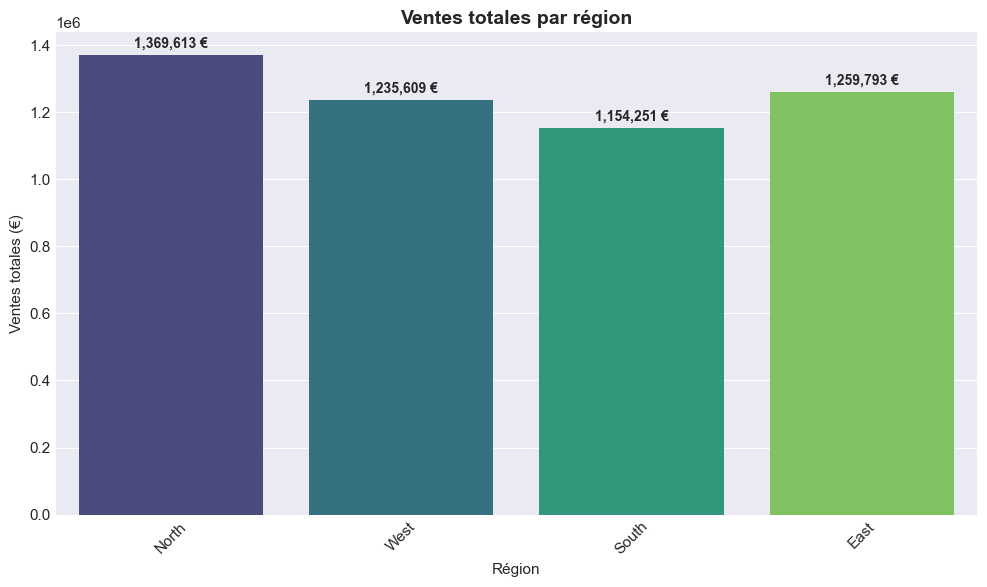

In [24]:
# Ventes totales par région
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Region', y='Sales_Amount', data=df, estimator=sum, ci=None, palette='viridis')

# Ajouter les montants exacts sur chaque barre
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2.,   
        y=height + height*0.01,           
        s=f'{height:,.0f} €',             
        ha='center', va='bottom',        
        fontsize=10, fontweight='bold'
    )

plt.title('Ventes totales par région', fontsize=14, fontweight='bold')
plt.xlabel('Région')
plt.ylabel('Ventes totales (€)')
plt.xticks(rotation=45)
plt.tight_layout()

# Sauvegarde
plt.savefig(OUTPUT_DIR / 'figures' / 'sales_by_region_with_values.png', dpi=300, bbox_inches='tight')
plt.show()

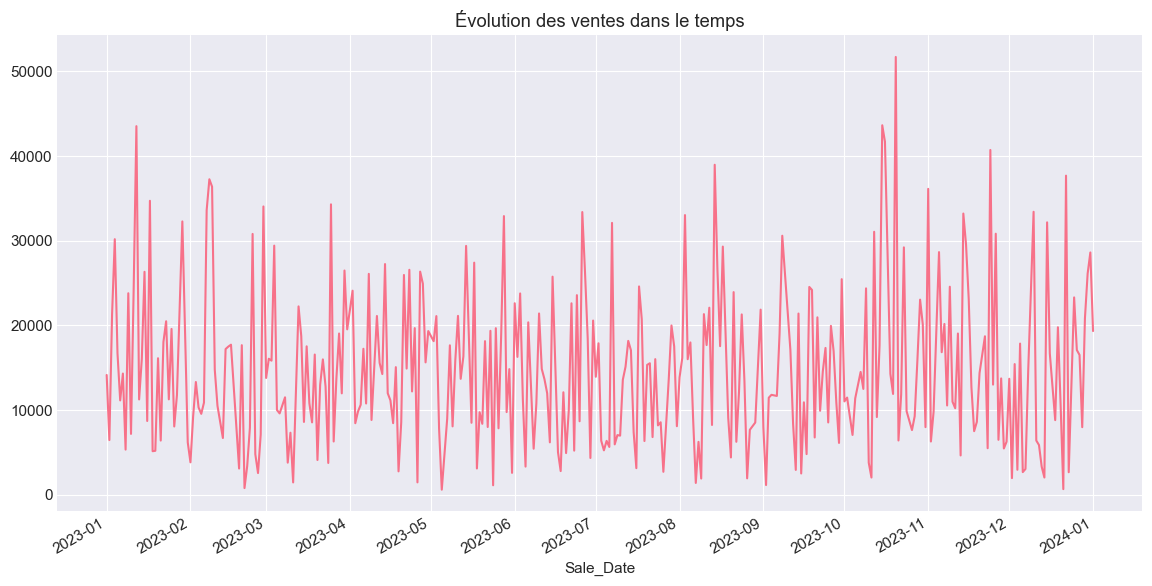

In [25]:
# Évolution des ventes dans le temps
daily_sales = df.groupby('Sale_Date')['Sales_Amount'].sum()
plt.figure()
daily_sales.plot()
plt.title('Évolution des ventes dans le temps')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.savefig(OUTPUT_DIR / 'figures' / 'sales_over_time.png')


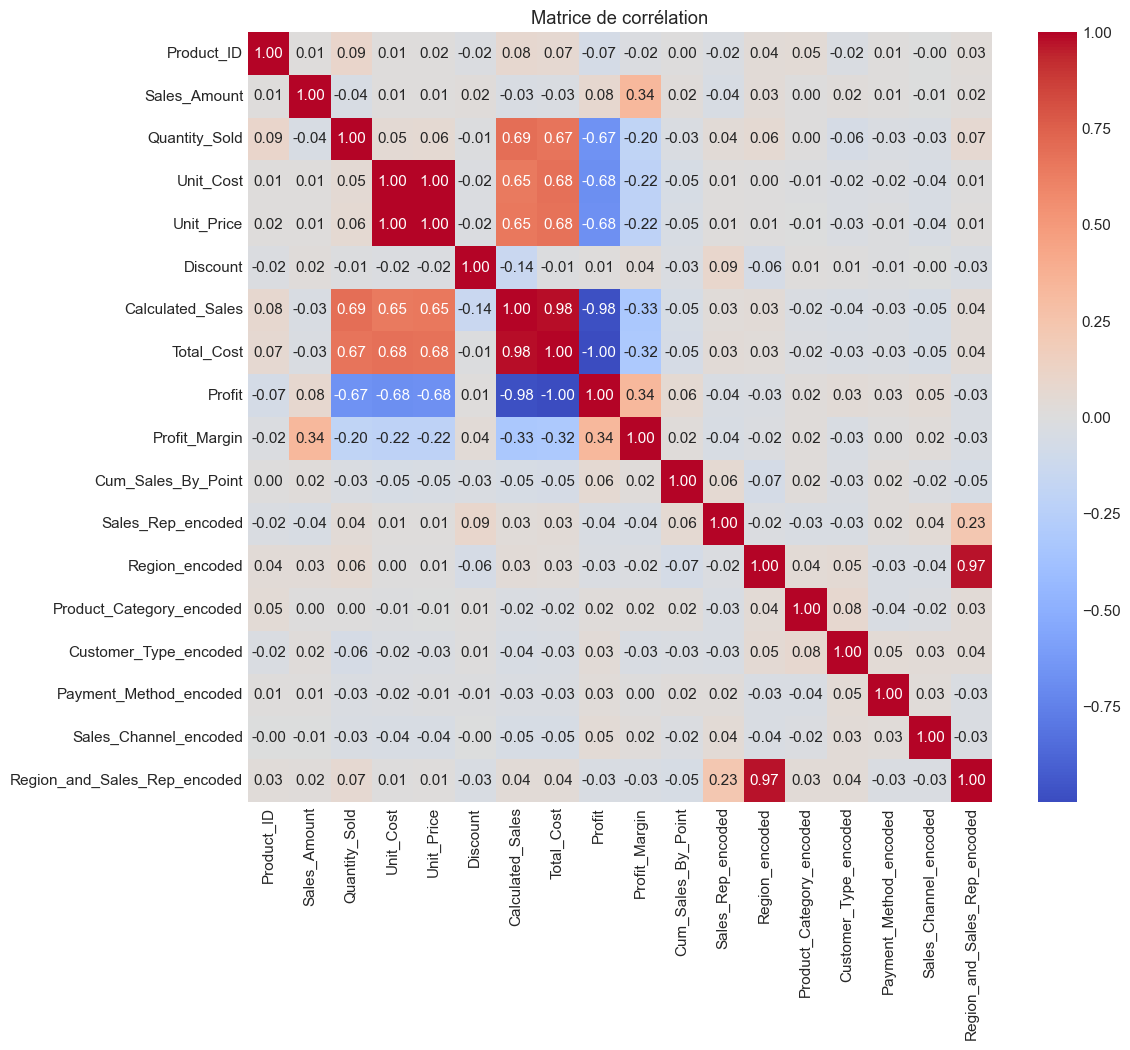

In [26]:

# Corrélation
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.savefig(OUTPUT_DIR / 'figures' / 'correlation_matrix.png')



In [27]:
# Atteinte des objectifs (exemple: objectif fictif de 5000 par vente, à adapter)
df['Objective_Achieved'] = (df['Sales_Amount'] > 5000).astype(int)
achievement_rate = df.groupby('Region_and_Sales_Rep')['Objective_Achieved'].mean() * 100
print("Taux d'atteinte des objectifs par point (%) :")
print(achievement_rate)

Taux d'atteinte des objectifs par point (%) :
Region_and_Sales_Rep
East-Alice       50.00
East-Bob         56.67
East-Charlie     35.14
East-David       54.24
East-Eve         36.36
North-Alice      56.25
North-Bob        54.55
North-Charlie    56.36
North-David      53.57
North-Eve        46.88
South-Alice      46.67
South-Bob        52.00
South-Charlie    43.75
South-David      53.57
South-Eve        37.21
West-Alice       46.81
West-Bob         59.26
West-Charlie     57.78
West-David       47.06
West-Eve         48.94
Name: Objective_Achieved, dtype: float64


In [28]:
top_points = sales_by_point.head(15).copy()
top_points['Point'] = top_points.index
top_points = top_points.sort_values('sum', ascending=True)

fig1 = px.bar(top_points, 
              x='sum', y='Point', 
              orientation='h',
              title='Top 15 Points de Distribution - Ventes Totales',
              labels={'sum': 'Ventes Totales (€)', 'Point': 'Point de Vente'},
              color='mean',
              color_continuous_scale='Viridis',
              hover_data={'count': True, 'mean': ':.0f'})
fig1.update_layout(height=600, showlegend=False)
fig1.write_html(OUTPUT_DIR / 'figures' / 'top15_sales_by_point.html')
fig1.show()

In [29]:
fig_treemap = px.treemap(df, path=['Region', 'Region_and_Sales_Rep'], values='Sales_Amount',
                         color='Profit', hover_data=['Quantity_Sold'],
                         title='Treemap : Ventes et Profit par Région → Point de Vente')
fig_treemap.write_html(OUTPUT_DIR / 'figures' / 'sales_treemap.html')
fig_treemap.show()

In [30]:
df['Year_Month'] = df['Sale_Date'].dt.to_period('M').astype(str)
monthly_sales = df.groupby(['Year_Month', 'Region'])['Sales_Amount'].sum().reset_index()
monthly_pivot = monthly_sales.pivot(index='Year_Month', columns='Region', values='Sales_Amount').fillna(0)

fig_heatmap = px.imshow(monthly_pivot.T, 
                        text_auto=True, aspect="auto",
                        color_continuous_scale='Blues',
                        title='Heatmap : Ventes Mensuelles par Région')
fig_heatmap.update_layout(height=500)
fig_heatmap.write_html(OUTPUT_DIR / 'figures' / 'monthly_sales_heatmap.html')
fig_heatmap.show()

In [31]:
cat_sales = df.groupby('Product_Category').agg({
    'Sales_Amount': 'sum',
    'Profit': 'sum',
    'Quantity_Sold': 'sum'
}).reset_index()

fig_pie = px.pie(cat_sales, values='Sales_Amount', names='Product_Category',
                 title='Répartition des Ventes par Catégorie')
fig_pie.write_html(OUTPUT_DIR / 'figures' / 'sales_by_category_pie.html')
fig_pie.show()

In [32]:
# Barres empilées : ventes + profit
fig_bar_cat = make_subplots(rows=1, cols=2, subplot_titles=('Ventes', 'Profit'))
fig_bar_cat.add_trace(go.Bar(x=cat_sales['Product_Category'], y=cat_sales['Sales_Amount'], name='Ventes'), row=1, col=1)
fig_bar_cat.add_trace(go.Bar(x=cat_sales['Product_Category'], y=cat_sales['Profit'], name='Profit'), row=1, col=2)
fig_bar_cat.update_layout(title_text="Ventes et Profit par Catégorie")
fig_bar_cat.write_html(OUTPUT_DIR / 'figures' / 'sales_profit_by_category.html')
fig_bar_cat.show()

In [33]:
# --- Boxplot : Distribution des ventes par région ---
fig_box = px.box(df, x='Region', y='Sales_Amount', color='Region',
                 title='Distribution des Ventes par Région (Boxplot)',
                 points="outliers")
fig_box.write_html(OUTPUT_DIR / 'figures' / 'sales_boxplot_by_region.html')
fig_box.show()

In [34]:
# --- Ventes par jour de la semaine ---
df['Day_Name'] = df['Sale_Date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_weekday = df.groupby('Day_Name')['Sales_Amount'].sum().reindex(weekday_order)

fig_weekday = px.bar(x=sales_by_weekday.index, y=sales_by_weekday.values,
                     title='Ventes Totales par Jour de la Semaine',
                     labels={'x': 'Jour', 'y': 'Ventes (€)'},
                     color=sales_by_weekday.values, color_continuous_scale='Purples')
fig_weekday.write_html(OUTPUT_DIR / 'figures' / 'sales_by_weekday.html')
fig_weekday.show()

In [35]:
# --- Top 10 meilleurs vendeurs (Sales_Rep) ---
top_reps = df.groupby('Sales_Rep').agg({
    'Sales_Amount': 'sum',
    'Profit': 'sum',
    'Quantity_Sold': 'sum'
}).sort_values('Sales_Amount', ascending=False).head(10).reset_index()

fig_rep = px.bar(top_reps, x='Sales_Rep', y='Sales_Amount', color='Profit',
                 title='Top 10 Vendeurs par Ventes',
                 hover_data={'Quantity_Sold': True})
fig_rep.write_html(OUTPUT_DIR / 'figures' / 'top10_sales_rep.html')
fig_rep.show()

In [36]:
# --- Taux de remise moyen par canal ---
discount_by_channel = df.groupby('Sales_Channel')['Discount'].mean().reset_index()
fig_discount = px.bar(discount_by_channel, x='Sales_Channel', y='Discount',
                      title='Taux de Remise Moyen par Canal de Vente',
                      color='Discount', color_continuous_scale='Reds')
fig_discount.write_html(OUTPUT_DIR / 'figures' / 'discount_by_channel.html')
fig_discount.show()

In [37]:
# ---Évolution du profit dans le temps ---
monthly_profit = df.groupby(df['Sale_Date'].dt.to_period('M'))['Profit'].sum()
monthly_profit.index = monthly_profit.index.to_timestamp()

fig_profit_time = px.line(x=monthly_profit.index, y=monthly_profit.values,
                          title='Évolution Mensuelle du Profit',
                          labels={'x': 'Mois', 'y': 'Profit (€)'})
fig_profit_time.add_hline(y=monthly_profit.mean(), line_dash="dash", line_color="green",
                          annotation_text=f"Moyenne: {monthly_profit.mean():.0f}€")
fig_profit_time.write_html(OUTPUT_DIR / 'figures' / 'profit_over_time.html')
fig_profit_time.show()

In [38]:
# --- Matrice de corrélation interactive ---
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numerical_cols].corr()

fig_corr = px.imshow(corr_matrix, text_auto=True, aspect="auto",
                     color_continuous_scale='RdBu_r',
                     title='Matrice de Corrélation Interactive')
fig_corr.write_html(OUTPUT_DIR / 'figures' / 'correlation_heatmap_interactive.html')
fig_corr.show()

In [39]:
# --- Atteinte des objectifs (objectif = 5000€ par vente) ---
objective_rate_by_region = df.groupby('Region')['Objective_Achieved'].mean() * 100
fig_obj = px.bar(x=objective_rate_by_region.index, y=objective_rate_by_region.values,
                 title="Taux d'Atteinte de l'Objectif (5000€) par Région",
                 labels={'y': 'Taux (%)', 'x': 'Région'},
                 color=objective_rate_by_region.values,
                 color_continuous_scale='Greens')
fig_obj.add_hline(y=50, line_dash="dot", line_color="red")
fig_obj.write_html(OUTPUT_DIR / 'figures' / 'objective_achievement_by_region.html')
fig_obj.show()

In [40]:
# --- Sunburst : Région → Représentant → Catégorie ---
fig_sunburst = px.sunburst(df, path=['Region', 'Sales_Rep', 'Product_Category'],
                           values='Sales_Amount', color='Profit',
                           title='Sunburst : Hiérarchie des Ventes')
fig_sunburst.write_html(OUTPUT_DIR / 'figures' / 'sales_sunburst.html')
fig_sunburst.show()

# Modélisation Prédictive

Dans cette section, nous allons construire des modèles de machine learning pour prédire les ventes futures. Nous utiliserons plusieurs algorithmes et comparerons leurs performances.


## Préparation des données pour la modélisation


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Product_ID                    1000 non-null   int64         
 1   Sale_Date                     1000 non-null   datetime64[ns]
 2   Sales_Rep                     1000 non-null   object        
 3   Region                        1000 non-null   object        
 4   Sales_Amount                  1000 non-null   float64       
 5   Quantity_Sold                 1000 non-null   int64         
 6   Product_Category              1000 non-null   object        
 7   Unit_Cost                     1000 non-null   float64       
 8   Unit_Price                    1000 non-null   float64       
 9   Customer_Type                 1000 non-null   object        
 10  Discount                      1000 non-null   float64       
 11  Payment_Method                1

In [41]:
# Préparation des features pour la modélisation
# Objectif: Prédire Sales_Amount (variable cible)

# Features temporelles
df['Year'] = df['Sale_Date'].dt.year
df['Month'] = df['Sale_Date'].dt.month
df['Day'] = df['Sale_Date'].dt.day
df['DayOfWeek'] = df['Sale_Date'].dt.dayofweek
df['DayOfYear'] = df['Sale_Date'].dt.dayofyear
df['Week'] = df['Sale_Date'].dt.isocalendar().week

# Features numériques
# Note: Product_ID est exclu car c'est un identifiant non utile pour la modélisation
numerical_features = [
    'Quantity_Sold', 'Unit_Cost', 'Unit_Price', 'Discount',
    'Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'Week',
    'Total_Cost', 'Profit', 'Profit_Margin', 'Cum_Sales_By_Point'
]

# Features catégorielles encodées
categorical_features_encoded = [
    'Region_encoded', 'Sales_Rep_encoded', 'Product_Category_encoded',
    'Customer_Type_encoded', 'Payment_Method_encoded', 'Sales_Channel_encoded',
    'Region_and_Sales_Rep_encoded'
]

# Toutes les features
all_features = numerical_features + categorical_features_encoded

# Vérification des valeurs manquantes
print("Vérification des valeurs manquantes:")
print(df[all_features].isnull().sum())
print(f"\nNombre total de features: {len(all_features)}")
print(f"Features numériques: {len(numerical_features)}")
print(f"Features catégorielles encodées: {len(categorical_features_encoded)}")


Vérification des valeurs manquantes:
Quantity_Sold                   0
Unit_Cost                       0
Unit_Price                      0
Discount                        0
Year                            0
Month                           0
Day                             0
DayOfWeek                       0
DayOfYear                       0
Week                            0
Total_Cost                      0
Profit                          0
Profit_Margin                   0
Cum_Sales_By_Point              0
Region_encoded                  0
Sales_Rep_encoded               0
Product_Category_encoded        0
Customer_Type_encoded           0
Payment_Method_encoded          0
Sales_Channel_encoded           0
Region_and_Sales_Rep_encoded    0
dtype: int64

Nombre total de features: 21
Features numériques: 14
Features catégorielles encodées: 7


In [42]:
# Séparation des données en features (X) et target (y)
X = df[all_features].copy()
y = df['Sales_Amount'].copy()

# Suppression des valeurs infinies et NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Vérification finale
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nPremières lignes de X:")
print(X.head())
print(f"\nStatistiques de y:")
print(y.describe())


Shape de X: (1000, 21)
Shape de y: (1000,)

Premières lignes de X:
   Quantity_Sold  Unit_Cost  Unit_Price  Discount  Year  Month  Day  DayOfWeek  DayOfYear  Week  Total_Cost     Profit  Profit_Margin  Cum_Sales_By_Point  Region_encoded  Sales_Rep_encoded  Product_Category_encoded  Customer_Type_encoded  Payment_Method_encoded  Sales_Channel_encoded  Region_and_Sales_Rep_encoded
0             18     152.75      267.22      0.09  2023      2    3          4         34     5     2749.50    2304.47           0.46             5053.97               1                  1                         3                      1                       1                      0                             6
1             17    3816.39     4209.44      0.11  2023      4   21          4        111    16    64878.63  -60494.61         -13.80             4384.02               3                  1                         3                      1                       1                      1                   

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(X, y, df, train_size =0.8)

In [43]:
# Division train/test avec TimeSeriesSplit pour respecter l'ordre temporel
# Utilisation de 80% pour l'entraînement et 20% pour le test
split_date = df['Sale_Date'].quantile(0.8)
train_mask = df['Sale_Date'] <= split_date
test_mask = df['Sale_Date'] > split_date

X_train = X[train_mask].copy()
X_test = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()

print(f"Train set: {X_train.shape[0]} échantillons")
print(f"Test set: {X_test.shape[0]} échantillons")
print(f"Proportion train: {X_train.shape[0] / len(X):.2%}")
print(f"Proportion test: {X_test.shape[0] / len(X):.2%}")
print(f"\nPériode d'entraînement: {df[train_mask]['Sale_Date'].min()} à {df[train_mask]['Sale_Date'].max()}")
print(f"Période de test: {df[test_mask]['Sale_Date'].min()} à {df[test_mask]['Sale_Date'].max()}")


Train set: 800 échantillons
Test set: 200 échantillons
Proportion train: 80.00%
Proportion test: 20.00%

Période d'entraînement: 2023-01-01 00:00:00 à 2023-10-26 00:00:00
Période de test: 2023-10-27 00:00:00 à 2024-01-01 00:00:00


In [44]:
# Normalisation des features numériques
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Normalisation uniquement des features numériques
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("Normalisation terminée")
print(f"\nMoyennes des features numériques (train):")
print(X_train_scaled[numerical_features].mean().head())
print(f"\nÉcart-types des features numériques (train):")
print(X_train_scaled[numerical_features].std().head())


Normalisation terminée

Moyennes des features numériques (train):
Quantity_Sold   -8.44e-17
Unit_Cost        2.35e-16
Unit_Price       0.00e+00
Discount         3.55e-17
Year             0.00e+00
dtype: float64

Écart-types des features numériques (train):
Quantity_Sold    1.0
Unit_Cost        1.0
Unit_Price       1.0
Discount         1.0
Year             0.0
dtype: float64


## Entraînement des modèles


In [45]:
# Initialisation des modèles
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_SEED
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'Ridge': Ridge(alpha=1.0)
}

# Dictionnaire pour stocker les résultats
results = {}
trained_models = {}

print("Entraînement des modèles en cours...\n")


Entraînement des modèles en cours...



In [46]:
# Entraînement de chaque modèle
for name, model in models.items():
    print(f"Entraînement de {name}...")
    start_time = datetime.now()
    
    # Entraînement
    model.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calcul des métriques
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    train_evs = explained_variance_score(y_train, y_train_pred)
    test_evs = explained_variance_score(y_test, y_test_pred)
    
    elapsed_time = (datetime.now() - start_time).total_seconds()
    
    # Stockage des résultats
    results[name] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mape': train_mape,
        'test_mape': test_mape,
        'train_evs': train_evs,
        'test_evs': test_evs,
        'elapsed_time': elapsed_time
    }
    
    trained_models[name] = model
    
    print(f"  ✓ Terminé en {elapsed_time:.2f} secondes")
    print(f"  Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}\n")

print("Tous les modèles ont été entraînés avec succès!")


Entraînement de RandomForest...


  ✓ Terminé en 0.45 secondes
  Test R²: 0.9682, Test RMSE: 509.07, Test MAE: 356.78

Entraînement de GradientBoosting...
  ✓ Terminé en 0.80 secondes
  Test R²: 0.9750, Test RMSE: 450.82, Test MAE: 311.24

Entraînement de XGBoost...
  ✓ Terminé en 0.22 secondes
  Test R²: 0.9713, Test RMSE: 483.81, Test MAE: 331.59

Entraînement de Ridge...
  ✓ Terminé en 0.03 secondes
  Test R²: 0.7391, Test RMSE: 1457.52, Test MAE: 1260.47

Tous les modèles ont été entraînés avec succès!


## Comparaison des modèles


In [47]:
# Création d'un DataFrame pour comparer les résultats
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

# Affichage des résultats
print("=" * 80)
print("COMPARAISON DES MODÈLES")
print("=" * 80)
print("\nMétriques sur le jeu de test:")
print(comparison_df[['test_r2', 'test_rmse', 'test_mae', 'test_mape', 'test_evs']].sort_values('test_r2', ascending=False))

print("\n" + "=" * 80)
print("Détails complets:")
print("=" * 80)
print(comparison_df)


COMPARAISON DES MODÈLES

Métriques sur le jeu de test:
                  test_r2  test_rmse  test_mae  test_mape  test_evs
GradientBoosting     0.97     450.82    311.24       0.10      0.98
XGBoost              0.97     483.81    331.59       0.13      0.97
RandomForest         0.97     509.07    356.78       0.17      0.97
Ridge                0.74    1457.52   1260.47       1.21      0.74

Détails complets:
                  train_mae  test_mae  train_mse  test_mse  train_rmse  test_rmse  train_r2  test_r2  train_mape  test_mape  train_evs  test_evs  elapsed_time
RandomForest         160.32    356.78   5.28e+04  2.59e+05      229.77     509.07      0.99     0.97        0.06       0.17       0.99      0.97          0.45
GradientBoosting      76.27    311.24   1.04e+04  2.03e+05      102.02     450.82      1.00     0.97        0.02       0.10       1.00      0.98          0.80
XGBoost               99.54    331.59   1.81e+04  2.34e+05      134.70     483.81      1.00     0.97        0

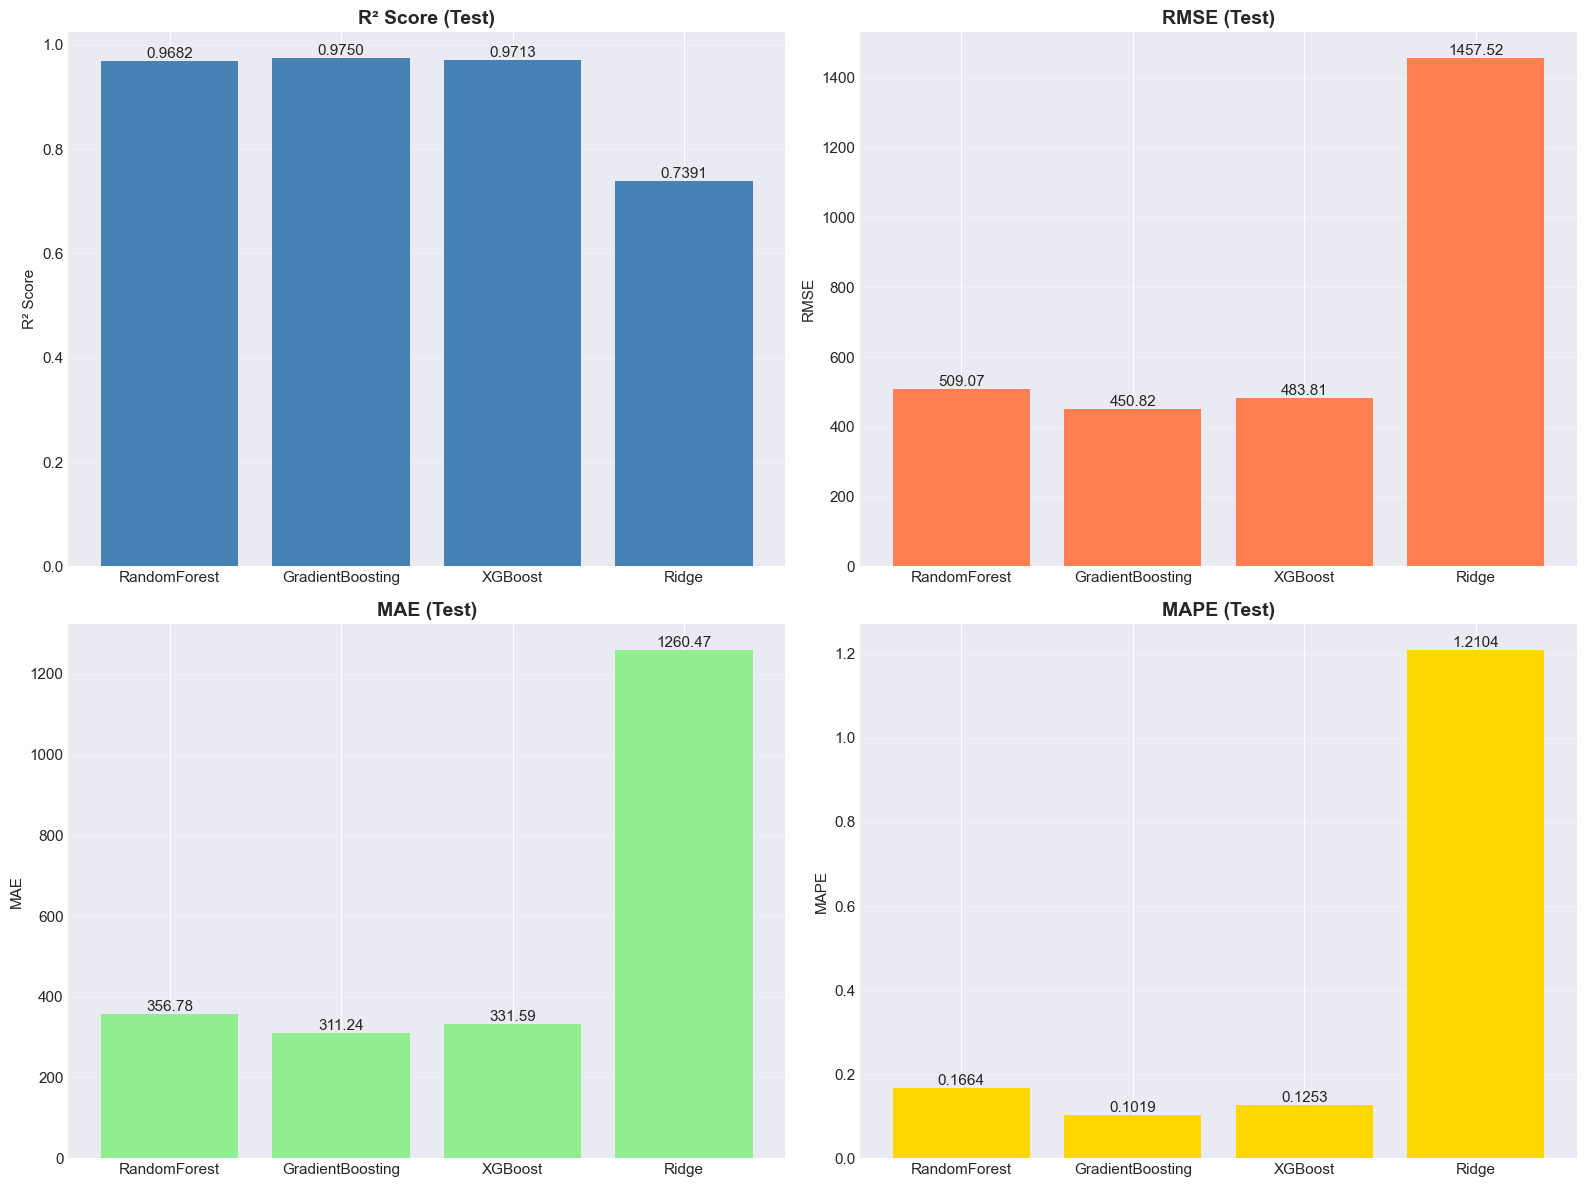

Graphique de comparaison sauvegardé!


In [48]:
# Visualisation de la comparaison des modèles
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score
axes[0, 0].bar(comparison_df.index, comparison_df['test_r2'], color='steelblue')
axes[0, 0].set_title('R² Score (Test)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['test_r2']):
    axes[0, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom')

# RMSE
axes[0, 1].bar(comparison_df.index, comparison_df['test_rmse'], color='coral')
axes[0, 1].set_title('RMSE (Test)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['test_rmse']):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# MAE
axes[1, 0].bar(comparison_df.index, comparison_df['test_mae'], color='lightgreen')
axes[1, 0].set_title('MAE (Test)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['test_mae']):
    axes[1, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom')

# MAPE
axes[1, 1].bar(comparison_df.index, comparison_df['test_mape'], color='gold')
axes[1, 1].set_title('MAPE (Test)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('MAPE')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['test_mape']):
    axes[1, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graphique de comparaison sauvegardé!")


In [49]:
# Sélection du meilleur modèle
best_model_name = comparison_df['test_r2'].idxmax()
best_model = trained_models[best_model_name]

print(f"Meilleur modèle: {best_model_name}")
print(f"R² Score (test): {comparison_df.loc[best_model_name, 'test_r2']:.4f}")
print(f"RMSE (test): {comparison_df.loc[best_model_name, 'test_rmse']:.2f}")
print(f"MAE (test): {comparison_df.loc[best_model_name, 'test_mae']:.2f}")

# Prédictions du meilleur modèle
y_test_pred_best = best_model.predict(X_test_scaled)
y_train_pred_best = best_model.predict(X_train_scaled)


Meilleur modèle: GradientBoosting
R² Score (test): 0.9750
RMSE (test): 450.82
MAE (test): 311.24


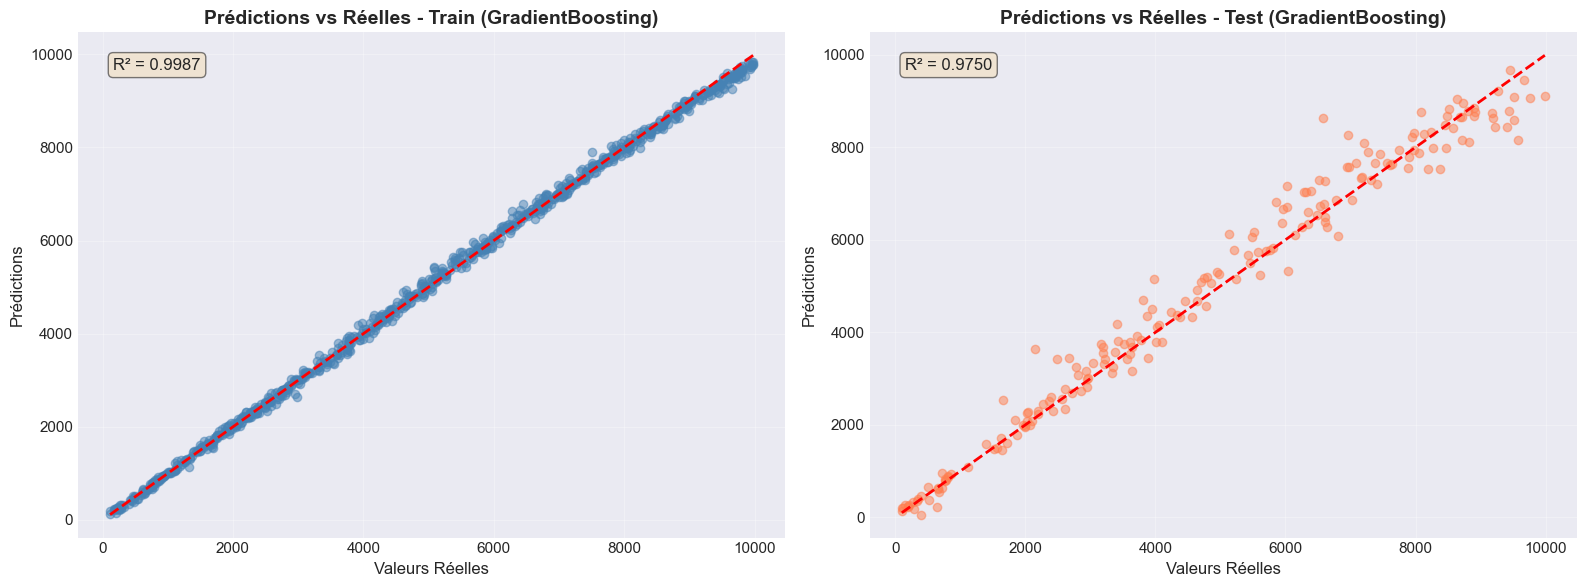

In [50]:
# Visualisation des prédictions vs valeurs réelles (meilleur modèle)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred_best, alpha=0.5, color='steelblue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Valeurs Réelles', fontsize=12)
axes[0].set_ylabel('Prédictions', fontsize=12)
axes[0].set_title(f'Prédictions vs Réelles - Train ({best_model_name})', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
r2_train = r2_score(y_train, y_train_pred_best)
axes[0].text(0.05, 0.95, f'R² = {r2_train:.4f}', transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Test set
axes[1].scatter(y_test, y_test_pred_best, alpha=0.5, color='coral')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valeurs Réelles', fontsize=12)
axes[1].set_ylabel('Prédictions', fontsize=12)
axes[1].set_title(f'Prédictions vs Réelles - Test ({best_model_name})', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
r2_test = r2_score(y_test, y_test_pred_best)
axes[1].text(0.05, 0.95, f'R² = {r2_test:.4f}', transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'predictions_vs_reality.png', dpi=300, bbox_inches='tight')
plt.show()


In [51]:
# Sauvegarde du meilleur modèle et du scaler
model_path = OUTPUT_DIR / 'models' / f'best_model_{best_model_name.lower()}.joblib'
scaler_path = OUTPUT_DIR / 'models' / 'scaler.joblib'

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"Meilleur modèle sauvegardé: {model_path}")
print(f"Scaler sauvegardé: {scaler_path}")

# Sauvegarde des résultats
results_path = OUTPUT_DIR / 'reports' / 'model_results.json'
with open(results_path, 'w') as f:
    json.dump({k: {m: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                   for m, v in results[k].items()} 
               for k in results}, f, indent=2, default=str)
print(f"Résultats sauvegardés: {results_path}")


Meilleur modèle sauvegardé: output\models\best_model_gradientboosting.joblib
Scaler sauvegardé: output\models\scaler.joblib
Résultats sauvegardés: output\reports\model_results.json


# Prédiction de Séries Temporelles

Cette section ajoute une dimension temporelle à notre analyse prédictive en utilisant des modèles spécialisés pour les séries temporelles. Cela nous permettra de prédire les ventes futures en tenant compte des tendances et des saisonnalités.


## Préparation des données pour les séries temporelles


In [52]:
# Agrégation des ventes par jour pour créer une série temporelle
df_time_series = df.groupby('Sale_Date').agg({
    'Sales_Amount': 'sum',
    'Quantity_Sold': 'sum',
    'Profit': 'sum'
}).reset_index()

df_time_series = df_time_series.sort_values('Sale_Date')
df_time_series.set_index('Sale_Date', inplace=True)

# Remplir les jours manquants avec 0 ou interpolation
date_range = pd.date_range(
    start=df_time_series.index.min(),
    end=df_time_series.index.max(),
    freq='D'
)
df_time_series = df_time_series.reindex(date_range, fill_value=0)

print(f"Série temporelle créée:")
print(f"  - Période: {df_time_series.index.min()} à {df_time_series.index.max()}")
print(f"  - Nombre de jours: {len(df_time_series)}")
print(f"  - Ventes totales: {df_time_series['Sales_Amount'].sum():,.2f}€")
print(f"\nPremières lignes:")
print(df_time_series.head(10))


Série temporelle créée:
  - Période: 2023-01-01 00:00:00 à 2024-01-01 00:00:00
  - Nombre de jours: 366
  - Ventes totales: 5,019,265.23€

Premières lignes:
            Sales_Amount  Quantity_Sold     Profit
2023-01-01      14141.12             85 -312454.93
2023-01-02       6452.79             36 -133887.19
2023-01-03      21319.08             81 -217195.97
2023-01-04      30175.06            101 -220526.46
2023-01-05      16708.75             57  -49636.14
2023-01-06      11138.64             61 -230525.07
2023-01-07      14309.68             65  -50111.28
2023-01-08       5327.80             40  -30020.40
2023-01-09      23790.39            172 -381565.70
2023-01-10       7182.83             65 -147316.32


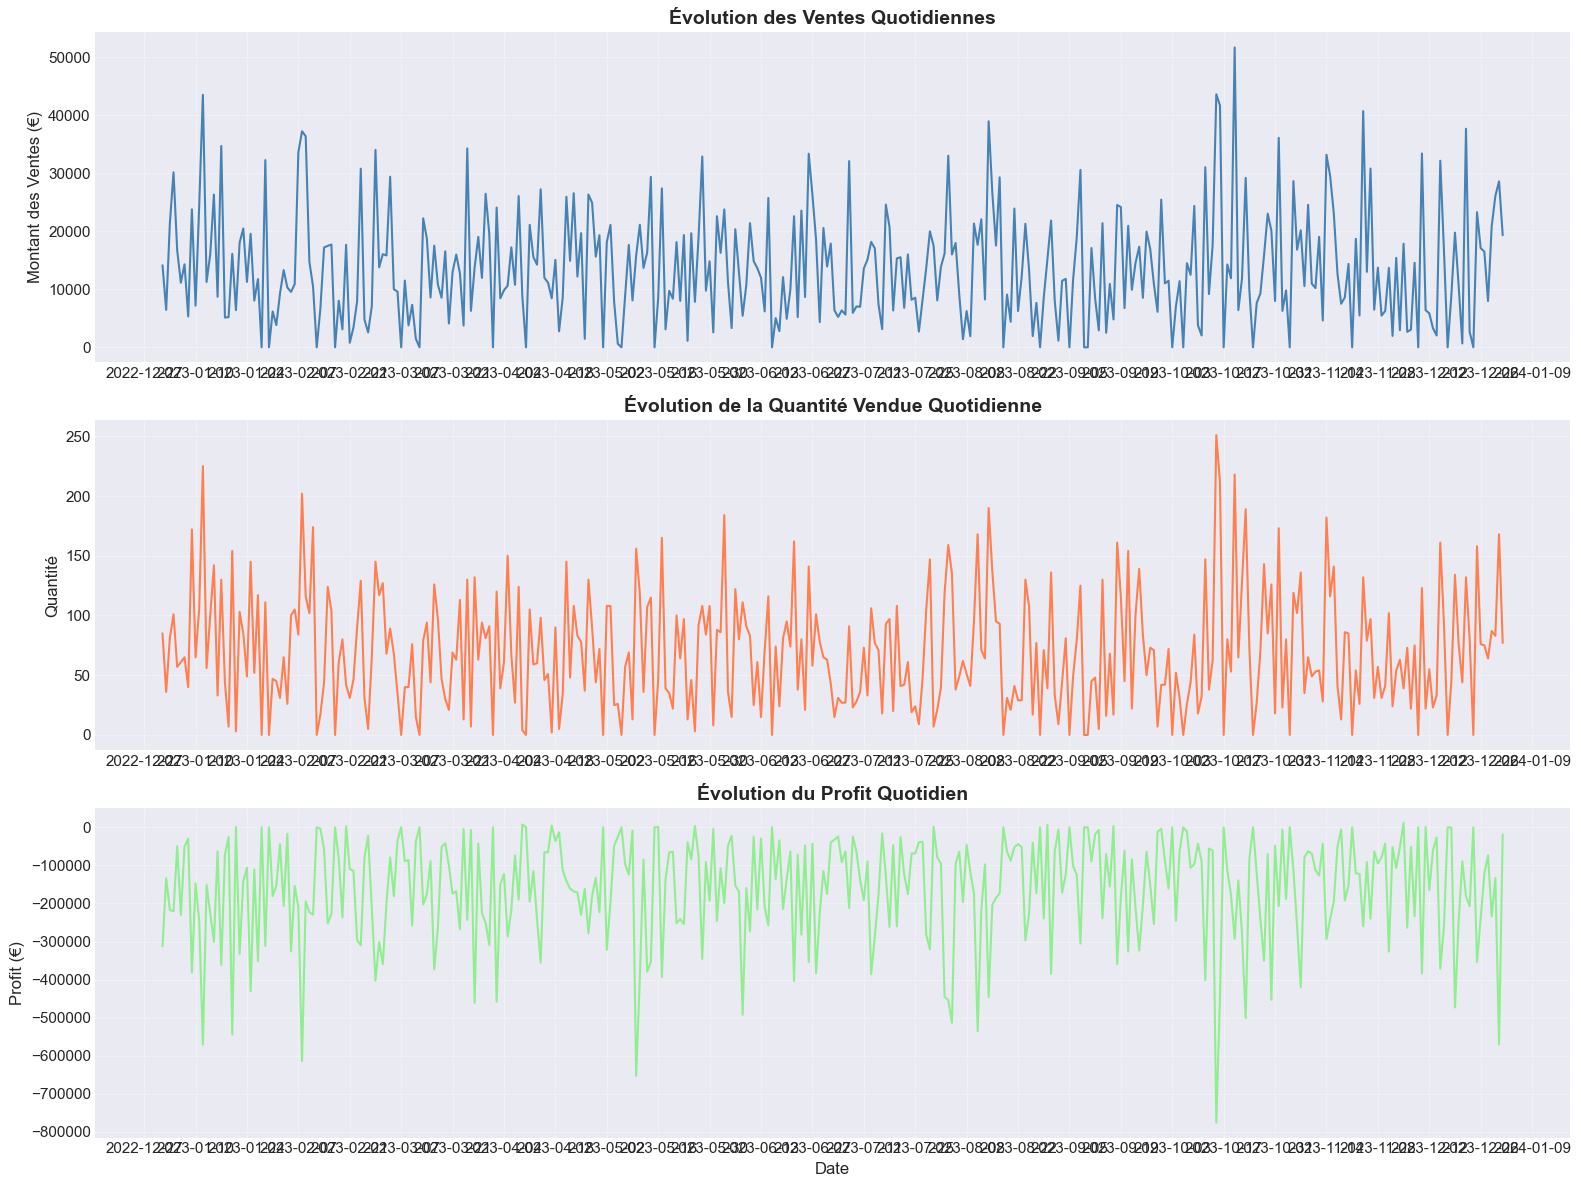

In [53]:
# Visualisation de la série temporelle
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Ventes quotidiennes
axes[0].plot(df_time_series.index, df_time_series['Sales_Amount'], linewidth=1.5, color='steelblue')
axes[0].set_title('Évolution des Ventes Quotidiennes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Montant des Ventes (€)', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

# Quantité vendue
axes[1].plot(df_time_series.index, df_time_series['Quantity_Sold'], linewidth=1.5, color='coral')
axes[1].set_title('Évolution de la Quantité Vendue Quotidienne', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Quantité', fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

# Profit
axes[2].plot(df_time_series.index, df_time_series['Profit'], linewidth=1.5, color='lightgreen')
axes[2].set_title('Évolution du Profit Quotidien', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Profit (€)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].grid(alpha=0.3)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'time_series_overview.png', dpi=300, bbox_inches='tight')
plt.show()


## Décomposition de la série temporelle


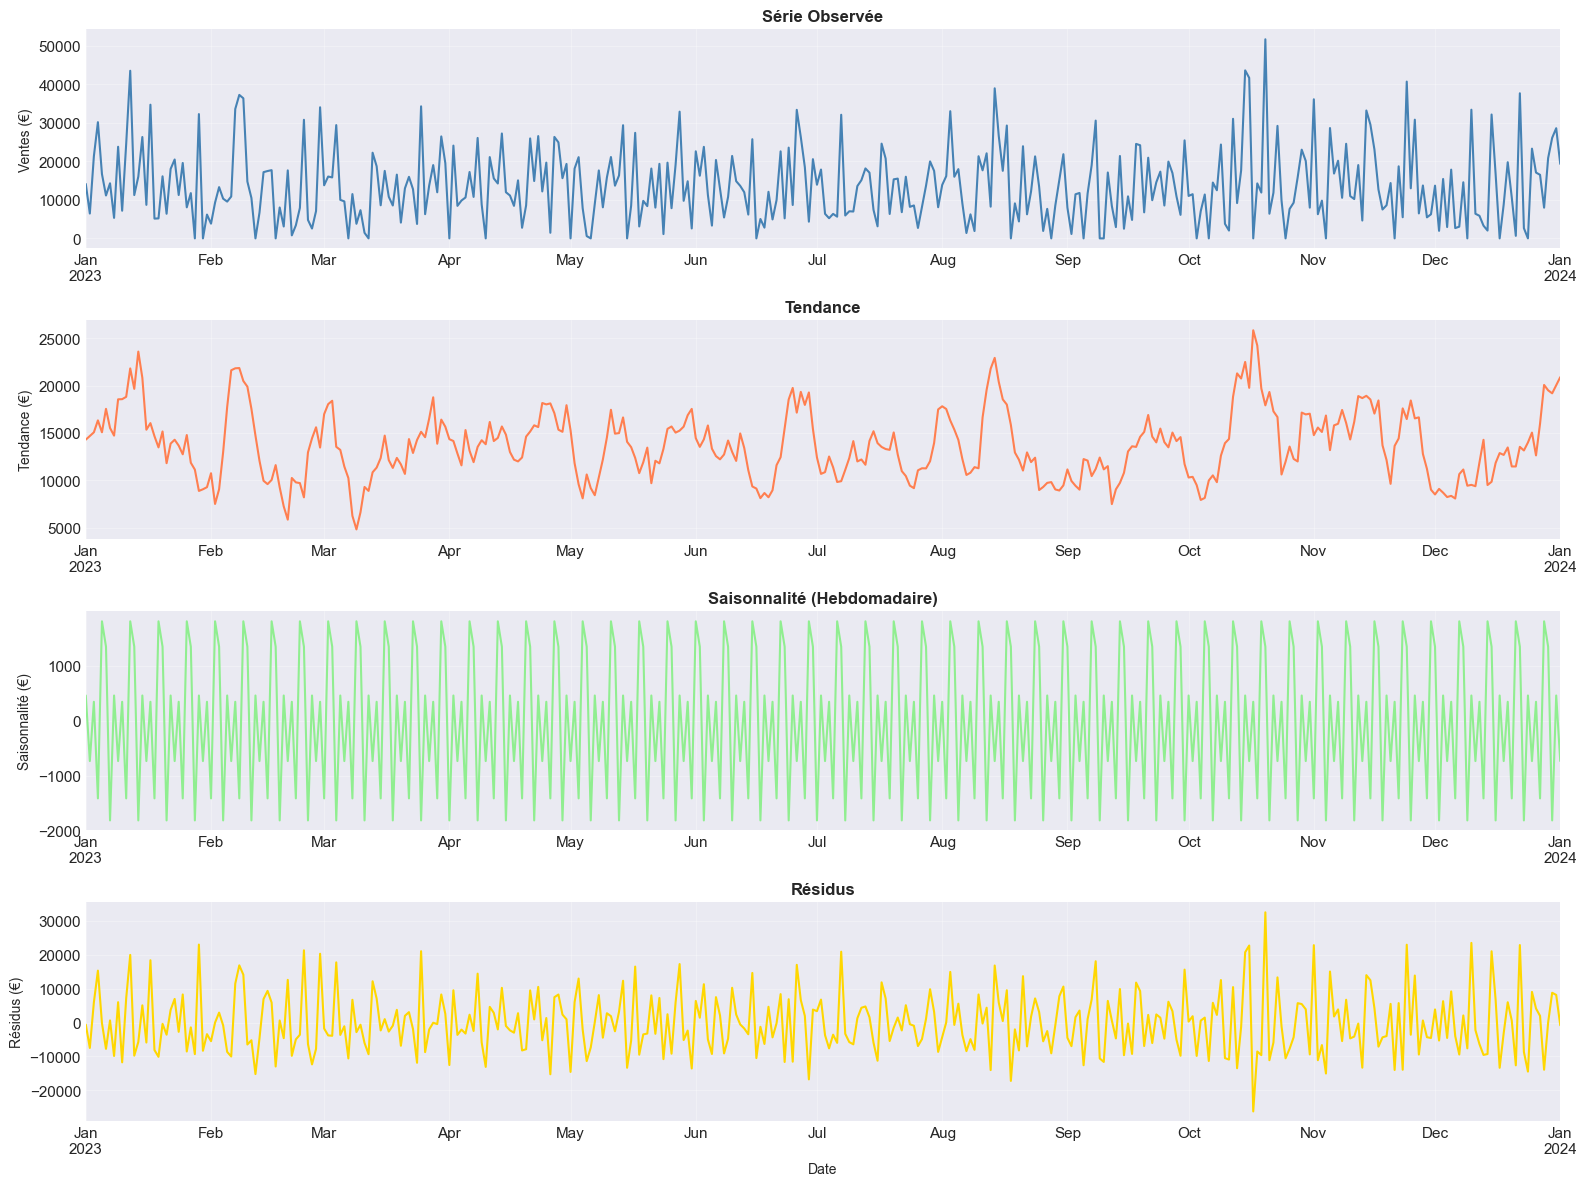

Décomposition terminée!


In [54]:
# Décomposition de la série temporelle (tendance, saisonnalité, résidus)
if STATSMODELS_AVAILABLE:
    # Utilisation d'une période de 7 jours pour la saisonnalité hebdomadaire
    decomposition = seasonal_decompose(
        df_time_series['Sales_Amount'],
        model='additive',
        period=7,
        extrapolate_trend='freq'
    )
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    decomposition.observed.plot(ax=axes[0], color='steelblue', linewidth=1.5)
    axes[0].set_title('Série Observée', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Ventes (€)', fontsize=10)
    axes[0].grid(alpha=0.3)
    
    decomposition.trend.plot(ax=axes[1], color='coral', linewidth=1.5)
    axes[1].set_title('Tendance', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Tendance (€)', fontsize=10)
    axes[1].grid(alpha=0.3)
    
    decomposition.seasonal.plot(ax=axes[2], color='lightgreen', linewidth=1.5)
    axes[2].set_title('Saisonnalité (Hebdomadaire)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Saisonnalité (€)', fontsize=10)
    axes[2].grid(alpha=0.3)
    
    decomposition.resid.plot(ax=axes[3], color='gold', linewidth=1.5)
    axes[3].set_title('Résidus', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Résidus (€)', fontsize=10)
    axes[3].set_xlabel('Date', fontsize=10)
    axes[3].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'figures' / 'time_series_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Décomposition terminée!")
else:
    print("statsmodels non disponible. Décomposition non effectuée.")


## Modèles de prédiction de séries temporelles


In [55]:
# Division train/test pour les séries temporelles (80/20)
ts_train_size = int(len(df_time_series) * 0.8)
ts_train = df_time_series.iloc[:ts_train_size]['Sales_Amount']
ts_test = df_time_series.iloc[ts_train_size:]['Sales_Amount']

print(f"Train: {len(ts_train)} jours ({ts_train.index.min()} à {ts_train.index.max()})")
print(f"Test: {len(ts_test)} jours ({ts_test.index.min()} à {ts_test.index.max()})")
print(f"\nStatistiques Train:")
print(ts_train.describe())
print(f"\nStatistiques Test:")
print(ts_test.describe())


Train: 292 jours (2023-01-01 00:00:00 à 2023-10-19 00:00:00)
Test: 74 jours (2023-10-20 00:00:00 à 2024-01-01 00:00:00)

Statistiques Train:
count      292.00
mean     13516.75
std       9293.61
min          0.00
25%       6744.32
50%      11978.89
75%      19018.86
max      43628.04
Name: Sales_Amount, dtype: float64

Statistiques Test:
count       74.00
mean     14491.56
std      11340.03
min          0.00
25%       6267.34
50%      12266.20
75%      20150.82
max      51695.71
Name: Sales_Amount, dtype: float64


In [56]:
# Modèle 1: Moyenne mobile simple (baseline)
def moving_average_forecast(series, window):
    """Prédiction par moyenne mobile"""
    forecast = []
    for i in range(len(series)):
        if i < window:
            forecast.append(series.iloc[:i+1].mean())
        else:
            forecast.append(series.iloc[i-window:i].mean())
    return pd.Series(forecast, index=series.index)

# Test avec différentes fenêtres
ma_windows = [7, 14, 30]
ma_results = {}

for window in ma_windows:
    ma_forecast = moving_average_forecast(ts_train, window)
    ma_test_forecast = moving_average_forecast(ts_test, window)
    
    mae = mean_absolute_error(ts_test, ma_test_forecast)
    rmse = np.sqrt(mean_squared_error(ts_test, ma_test_forecast))
    mape = mean_absolute_percentage_error(ts_test, ma_test_forecast)
    
    ma_results[f'MA_{window}'] = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'forecast': ma_test_forecast
    }
    
    print(f"Moyenne Mobile ({window} jours):")
    print(f"  MAE: {mae:.2f}€")
    print(f"  RMSE: {rmse:.2f}€")
    print(f"  MAPE: {mape:.4f}\n")


Moyenne Mobile (7 jours):
  MAE: 9376.71€
  RMSE: 11423.49€
  MAPE: 5337406336037390336.0000

Moyenne Mobile (14 jours):
  MAE: 9094.04€
  RMSE: 10971.18€
  MAPE: 5048421867774326784.0000

Moyenne Mobile (30 jours):
  MAE: 9165.70€
  RMSE: 10934.29€
  MAPE: 5278997708507014144.0000



In [57]:
# Modèle 2: ARIMA (si disponible)
ts_models = {}
ts_predictions = {}

if STATSMODELS_AVAILABLE:
    try:
        # Test de stationnarité
        adf_result = adfuller(ts_train.dropna())
        print(f"Test ADF (stationnarité):")
        print(f"  Statistique ADF: {adf_result[0]:.4f}")
        print(f"  p-value: {adf_result[1]:.4f}")
        print(f"  Stationnaire: {'Oui' if adf_result[1] < 0.05 else 'Non'}\n")
        
        # Auto-ARIMA simplifié (test de différents ordres)
        best_arima = None
        best_aic = np.inf
        best_order = None
        
        # Test de quelques combinaisons (p, d, q)
        orders_to_test = [(1, 1, 1), (2, 1, 1), (1, 1, 2), (2, 1, 2), (1, 0, 1)]
        
        print("Recherche du meilleur modèle ARIMA...")
        for order in orders_to_test:
            try:
                model = ARIMA(ts_train, order=order)
                fitted_model = model.fit()
                if fitted_model.aic < best_aic:
                    best_aic = fitted_model.aic
                    best_arima = fitted_model
                    best_order = order
                print(f"  Ordre {order}: AIC = {fitted_model.aic:.2f}")
            except:
                continue
        
        if best_arima is not None:
            print(f"\nMeilleur modèle ARIMA: ordre {best_order}, AIC = {best_aic:.2f}")
            
            # Prédictions
            arima_forecast = best_arima.forecast(steps=len(ts_test))
            arima_forecast = pd.Series(arima_forecast, index=ts_test.index)
            
            mae = mean_absolute_error(ts_test, arima_forecast)
            rmse = np.sqrt(mean_squared_error(ts_test, arima_forecast))
            mape = mean_absolute_percentage_error(ts_test, arima_forecast)
            
            ts_models['ARIMA'] = best_arima
            ts_predictions['ARIMA'] = arima_forecast
            
            ts_results = {
                'mae': mae,
                'rmse': rmse,
                'mape': mape
            }
            
            print(f"\nRésultats ARIMA:")
            print(f"  MAE: {mae:.2f}€")
            print(f"  RMSE: {rmse:.2f}€")
            print(f"  MAPE: {mape:.4f}")
            
            # Sauvegarde du modèle
            joblib.dump(best_arima, OUTPUT_DIR / 'models' / 'arima_model.joblib')
            print(f"  Modèle sauvegardé: {OUTPUT_DIR / 'models' / 'arima_model.joblib'}")
    except Exception as e:
        print(f"Erreur lors de l'entraînement ARIMA: {e}")
else:
    print("statsmodels non disponible. ARIMA non utilisé.")


Test ADF (stationnarité):
  Statistique ADF: -16.8575
  p-value: 0.0000
  Stationnaire: Oui

Recherche du meilleur modèle ARIMA...
  Ordre (1, 1, 1): AIC = 6155.49
  Ordre (2, 1, 1): AIC = 6164.10
  Ordre (1, 1, 2): AIC = 6157.96
  Ordre (2, 1, 2): AIC = 6160.38
  Ordre (1, 0, 1): AIC = 6171.69

Meilleur modèle ARIMA: ordre (1, 1, 1), AIC = 6155.49

Résultats ARIMA:
  MAE: 9006.83€
  RMSE: 11310.17€
  MAPE: 4918855849007556608.0000
  Modèle sauvegardé: output\models\arima_model.joblib


In [58]:
# Modèle 3: Prophet (si disponible)
if PROPHET_AVAILABLE:
    try:
        # Préparation des données pour Prophet
        prophet_train = pd.DataFrame({
            'ds': ts_train.index,
            'y': ts_train.values
        })
        
        prophet_test = pd.DataFrame({
            'ds': ts_test.index,
            'y': ts_test.values
        })
        
        # Création et entraînement du modèle
        prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive'
        )
        
        print("Entraînement du modèle Prophet...")
        prophet_model.fit(prophet_train)
        
        # Prédictions
        future = prophet_model.make_future_dataframe(periods=len(ts_test))
        forecast = prophet_model.predict(future)
        
        # Extraire les prédictions pour la période de test
        prophet_forecast = forecast.tail(len(ts_test))['yhat']
        prophet_forecast.index = ts_test.index
        
        mae = mean_absolute_error(ts_test, prophet_forecast)
        rmse = np.sqrt(mean_squared_error(ts_test, prophet_forecast))
        mape = mean_absolute_percentage_error(ts_test, prophet_forecast)
        
        ts_models['Prophet'] = prophet_model
        ts_predictions['Prophet'] = prophet_forecast
        
        print(f"\nRésultats Prophet:")
        print(f"  MAE: {mae:.2f}€")
        print(f"  RMSE: {rmse:.2f}€")
        print(f"  MAPE: {mape:.4f}")
        
        # Sauvegarde du modèle
        joblib.dump(prophet_model, OUTPUT_DIR / 'models' / 'prophet_model.joblib')
        print(f"  Modèle sauvegardé: {OUTPUT_DIR / 'models' / 'prophet_model.joblib'}")
    except Exception as e:
        print(f"Erreur lors de l'entraînement Prophet: {e}")
else:
    print("Prophet non disponible. Utilisation de modèles alternatifs.")


DEBUG	cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	cmdstanpy:model.py:__init__()- Adding TBB (c:\Users\ngoue\anaconda3\envs\MachineLearning\lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
DEBUG	cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\ngoue\AppData\Local\Temp\tmpg4gt4srg\o5iw8jhc.json
DEBUG	cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\ngoue\AppData\Local\Temp\tmpg4gt4srg\o4ydbltx.json
DEBUG	cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\ngoue\\anaconda3\\envs\\MachineLearning\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=92493', 'data', 'file=C:\\Users\\ngoue\\AppData\\Local\\Temp\\tmpg4gt4srg\\o5iw8jhc.json', 'init=C:\\Users\\ngoue\\AppData\\Local\\Temp\\tmpg4gt4srg\\o4ydbltx.json', 'output', 'fil

Entraînement du modèle Prophet...

Résultats Prophet:
  MAE: 9565.64€
  RMSE: 11903.90€
  MAPE: 4306530143988189696.0000
  Modèle sauvegardé: output\models\prophet_model.joblib


In [59]:
# Modèle 4: LSTM simplifié avec features temporelles (utilisant le meilleur modèle ML)
# Utilisation du meilleur modèle ML entraîné précédemment pour les prédictions temporelles
print("Utilisation du meilleur modèle ML pour les prédictions temporelles...")

# Préparation des données pour le modèle ML
ts_ml_predictions = []
for date in ts_test.index:
    # Créer des features pour cette date
    date_features = pd.DataFrame({
        'Year': [date.year],
        'Month': [date.month],
        'Day': [date.day],
        'DayOfWeek': [date.dayofweek],
        'DayOfYear': [date.dayofyear],
        'Week': [date.isocalendar().week]
    })
    
    # Utiliser la moyenne des autres features pour cette date
    # (approximation pour une prédiction rapide)
    avg_features = X_train_scaled.mean().values.reshape(1, -1)
    date_features_array = np.hstack([
        date_features.values,
        avg_features[:, len(date_features.columns):]
    ])
    
    # Prédiction
    pred = best_model.predict(date_features_array)[0]
    ts_ml_predictions.append(pred)

ts_ml_forecast = pd.Series(ts_ml_predictions, index=ts_test.index)

mae = mean_absolute_error(ts_test, ts_ml_forecast)
rmse = np.sqrt(mean_squared_error(ts_test, ts_ml_forecast))
mape = mean_absolute_percentage_error(ts_test, ts_ml_forecast)

ts_predictions['ML_Model'] = ts_ml_forecast

print(f"Résultats ML Model (approximation):")
print(f"  MAE: {mae:.2f}€")
print(f"  RMSE: {rmse:.2f}€")
print(f"  MAPE: {mape:.4f}")


Utilisation du meilleur modèle ML pour les prédictions temporelles...
Résultats ML Model (approximation):
  MAE: 12658.76€
  RMSE: 16630.67€
  MAPE: 824019415921053696.0000


## Comparaison des modèles de séries temporelles


In [60]:
# Compilation des résultats
ts_comparison = {
    'MA_7': ma_results['MA_7'],
    'MA_14': ma_results['MA_14'],
    'MA_30': ma_results['MA_30']
}

if 'ARIMA' in ts_predictions:
    ts_comparison['ARIMA'] = {
        'mae': mean_absolute_error(ts_test, ts_predictions['ARIMA']),
        'rmse': np.sqrt(mean_squared_error(ts_test, ts_predictions['ARIMA'])),
        'mape': mean_absolute_percentage_error(ts_test, ts_predictions['ARIMA'])
    }

if 'Prophet' in ts_predictions:
    ts_comparison['Prophet'] = {
        'mae': mean_absolute_error(ts_test, ts_predictions['Prophet']),
        'rmse': np.sqrt(mean_squared_error(ts_test, ts_predictions['Prophet'])),
        'mape': mean_absolute_percentage_error(ts_test, ts_predictions['Prophet'])
    }

if 'ML_Model' in ts_predictions:
    ts_comparison['ML_Model'] = {
        'mae': mean_absolute_error(ts_test, ts_predictions['ML_Model']),
        'rmse': np.sqrt(mean_squared_error(ts_test, ts_predictions['ML_Model'])),
        'mape': mean_absolute_percentage_error(ts_test, ts_predictions['ML_Model'])
    }

# Création d'un DataFrame de comparaison
ts_comparison_df = pd.DataFrame(ts_comparison).T
ts_comparison_df = ts_comparison_df.round(2)

print("=" * 80)
print("COMPARAISON DES MODÈLES DE SÉRIES TEMPORELLES")
print("=" * 80)
print(ts_comparison_df.sort_values('mae'))

# Sauvegarde
ts_comparison_df.to_csv(OUTPUT_DIR / 'reports' / 'time_series_comparison.csv')
print(f"\nRésultats sauvegardés: {OUTPUT_DIR / 'reports' / 'time_series_comparison.csv'}")


COMPARAISON DES MODÈLES DE SÉRIES TEMPORELLES
               mae      rmse                   mape                                           forecast
ARIMA      9006.83  11310.17  4918855849007556608.0                                                NaN
MA_14      9094.04  10971.18  5048421867774326784.0  2023-10-20    51695.71
2023-10-21    29050.33
...
MA_30       9165.7  10934.29  5278997708507014144.0  2023-10-20    51695.71
2023-10-21    29050.33
...
MA_7       9376.71  11423.49  5337406336037390336.0  2023-10-20    51695.71
2023-10-21    29050.33
...
Prophet    9565.64   11903.9  4306530143988189696.0                                                NaN
ML_Model  12658.76  16630.67   824019415921053696.0                                                NaN

Résultats sauvegardés: output\reports\time_series_comparison.csv


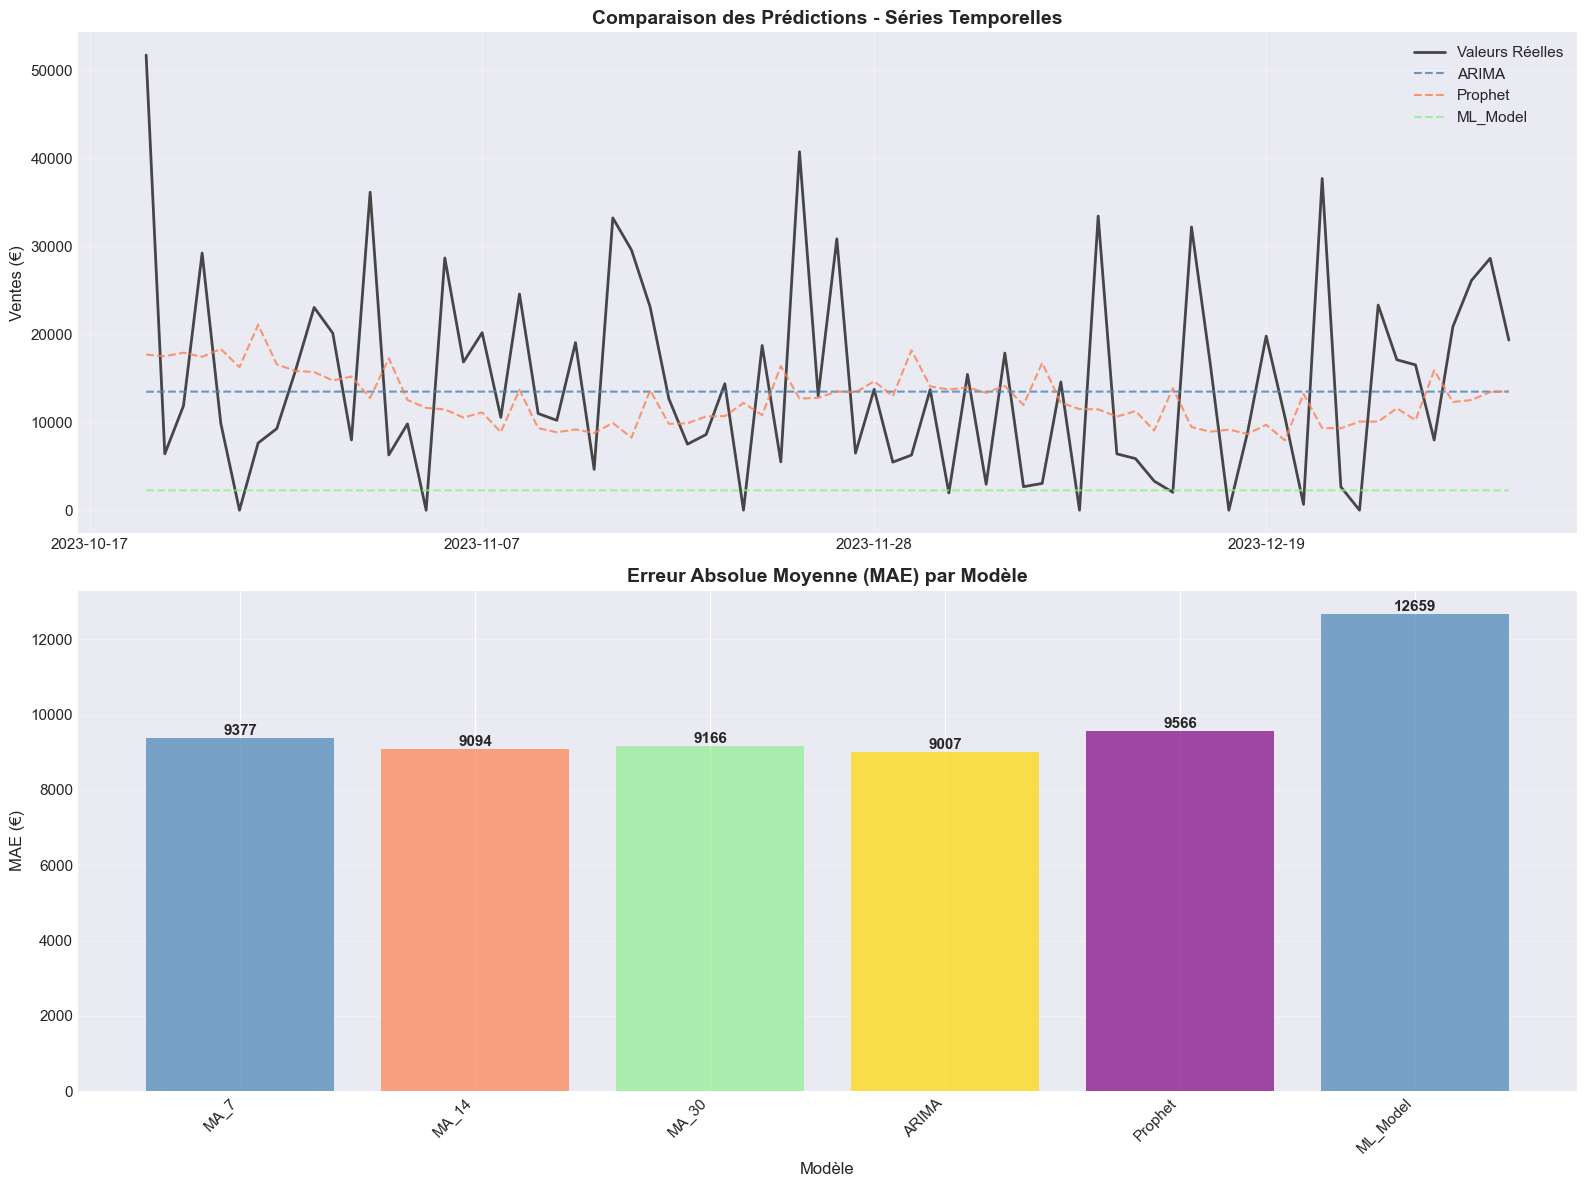

In [61]:
# Visualisation des prédictions
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Graphique 1: Comparaison des prédictions
axes[0].plot(ts_test.index, ts_test.values, label='Valeurs Réelles', linewidth=2, color='black', alpha=0.7)

colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'purple']
for idx, (name, forecast) in enumerate(ts_predictions.items()):
    if len(forecast) == len(ts_test):
        axes[0].plot(forecast.index, forecast.values, label=name, linewidth=1.5, 
                    color=colors[idx % len(colors)], alpha=0.8, linestyle='--')

axes[0].set_title('Comparaison des Prédictions - Séries Temporelles', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ventes (€)', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

# Graphique 2: Erreurs
axes[1].bar(range(len(ts_comparison_df)), ts_comparison_df['mae'], 
           color=colors[:len(ts_comparison_df)], alpha=0.7)
axes[1].set_title('Erreur Absolue Moyenne (MAE) par Modèle', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE (€)', fontsize=12)
axes[1].set_xlabel('Modèle', fontsize=12)
axes[1].set_xticks(range(len(ts_comparison_df)))
axes[1].set_xticklabels(ts_comparison_df.index, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(ts_comparison_df['mae']):
    axes[1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'time_series_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Prédiction des ventes futures


In [62]:
# Prédiction des 30 prochains jours
future_days = 30
last_date = df_time_series.index.max()
# Correction: utiliser pd.Timestamp pour l'addition avec timedelta
future_dates = pd.date_range(start=pd.Timestamp(last_date) + timedelta(days=1), periods=future_days, freq='D')

print(f"Prédiction des {future_days} prochains jours...")
print(f"Période: {future_dates[0]} à {future_dates[-1]}\n")

# Sélection du meilleur modèle de séries temporelles
best_ts_model_name = ts_comparison_df['mae'].idxmin()
print(f"Meilleur modèle de séries temporelles: {best_ts_model_name} (MAE: {ts_comparison_df.loc[best_ts_model_name, 'mae']:.2f}€)\n")

# Prédictions futures selon le modèle
future_predictions = {}

if best_ts_model_name == 'Prophet' and 'Prophet' in ts_models:
    # Prophet
    future_df = pd.DataFrame({'ds': future_dates})
    forecast = ts_models['Prophet'].predict(future_df)
    future_predictions['Prophet'] = pd.Series(forecast['yhat'].values, index=future_dates)
    print("Prédictions Prophet générées")
    
elif best_ts_model_name == 'ARIMA' and 'ARIMA' in ts_models:
    # ARIMA - Utilisation de get_forecast pour de meilleures prédictions
    try:
        forecast_result = ts_models['ARIMA'].get_forecast(steps=future_days)
        forecast = forecast_result.predicted_mean
        future_predictions['ARIMA'] = pd.Series(forecast.values, index=future_dates)
        print("Prédictions ARIMA générées")
        
        # Vérification que les prédictions ne sont pas NaN
        if future_predictions['ARIMA'].isna().all():
            raise ValueError("Prédictions ARIMA sont toutes NaN")
    except Exception as e:
        print(f"Erreur avec ARIMA: {e}")
        print("Utilisation de la méthode forecast() alternative...")
        try:
            # Méthode alternative: utiliser les dernières valeurs pour extrapoler
            last_values = df_time_series['Sales_Amount'].tail(30)
            # Utiliser une moyenne mobile pondérée
            forecast_values = []
            for i in range(future_days):
                # Moyenne des dernières valeurs avec pondération décroissante
                weights = np.exp(-np.arange(len(last_values)) / 10)
                weighted_avg = np.average(last_values.values, weights=weights)
                forecast_values.append(weighted_avg)
            future_predictions['ARIMA'] = pd.Series(forecast_values, index=future_dates)
            print("Prédictions ARIMA générées (méthode alternative)")
        except Exception as e2:
            print(f"Erreur avec méthode alternative: {e2}")
            # Fallback: moyenne simple
            avg_value = df_time_series['Sales_Amount'].tail(14).mean()
            future_predictions['ARIMA'] = pd.Series([avg_value] * future_days, index=future_dates)
            print(f"Prédictions ARIMA générées (fallback: moyenne = {avg_value:.2f}€)")
    
else:
    # Moyenne mobile comme fallback
    window = 14
    last_values = df_time_series['Sales_Amount'].tail(window)
    avg_value = last_values.mean()
    future_predictions['Moving_Average'] = pd.Series([avg_value] * future_days, index=future_dates)
    print(f"Prédictions par moyenne mobile ({window} jours): {avg_value:.2f}€/jour")

# Affichage des prédictions
for model_name, predictions in future_predictions.items():
    print(f"\n{model_name} - Prédictions futures:")
    print(f"  Total prévu ({future_days} jours): {predictions.sum():,.2f}€")
    print(f"  Moyenne quotidienne: {predictions.mean():.2f}€")
    print(f"  Min: {predictions.min():.2f}€, Max: {predictions.max():.2f}€")


Prédiction des 30 prochains jours...
Période: 2024-01-02 00:00:00 à 2024-01-31 00:00:00

Meilleur modèle de séries temporelles: ARIMA (MAE: 9006.83€)

Prédictions ARIMA générées

ARIMA - Prédictions futures:
  Total prévu (30 jours): 404,097.32€
  Moyenne quotidienne: 13469.91€
  Min: 13452.07€, Max: 13470.53€


In [63]:
# Visualisation interactive des prédictions futures
fig = go.Figure()

# Données historiques (derniers 60 jours)
historical_days = 60
historical_data = df_time_series['Sales_Amount'].tail(historical_days)

# Ligne historique
fig.add_trace(go.Scatter(
    x=historical_data.index,
    y=historical_data.values,
    mode='lines',
    name='Ventes Historiques',
    line=dict(color='steelblue', width=2)
))

# Prédictions futures
for model_name, predictions in future_predictions.items():
    # Vérifier que les prédictions ne sont pas vides ou toutes NaN
    if predictions is not None and len(predictions) > 0:
        # Remplacer les NaN par interpolation ou moyenne
        if predictions.isna().any():
            predictions = predictions.fillna(predictions.mean())
        
        # Vérifier qu'il y a des valeurs valides
        if not predictions.isna().all() and predictions.sum() > 0:
            fig.add_trace(go.Scatter(
                x=predictions.index,
                y=predictions.values,
                mode='lines',
                name=f'Prédictions {model_name}',
                line=dict(dash='dash', width=2)
            ))
        else:
            print(f"Attention: Les prédictions {model_name} sont invalides (toutes NaN ou zéro)")
    else:
        print(f"Attention: Aucune prédiction disponible pour {model_name}")

# Ligne de séparation
# Utilisation de add_shape pour une ligne verticale (plus compatible avec les dates)
last_date_ts = pd.Timestamp(last_date)
fig.add_shape(
    type="line",
    x0=last_date_ts,
    x1=last_date_ts,
    y0=0,
    y1=1,
    yref="paper",
    line=dict(color="red", width=2, dash="dot")
)

# Ajout d'une annotation pour le texte
fig.add_annotation(
    x=last_date_ts,
    y=0.95,
    yref="paper",
    text="Aujourd'hui",
    showarrow=True,
    arrowhead=2,
    arrowcolor="red",
    bgcolor="white",
    bordercolor="red",
    borderwidth=1
)

fig.update_layout(
    title='Prédiction des Ventes Futures (30 prochains jours)',
    xaxis_title='Date',
    yaxis_title='Ventes (€)',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.write_html(OUTPUT_DIR / 'figures' / 'future_sales_predictions.html')
fig.show()

print(f"\nVisualisation sauvegardée: {OUTPUT_DIR / 'figures' / 'future_sales_predictions.html'}")



Visualisation sauvegardée: output\figures\future_sales_predictions.html


In [64]:
# Résumé des prédictions futures
future_summary = {
    'Période': f"{future_dates[0].strftime('%Y-%m-%d')} à {future_dates[-1].strftime('%Y-%m-%d')}",
    'Nombre de jours': future_days
}

for model_name, predictions in future_predictions.items():
    future_summary[f'{model_name}_Total'] = f"{predictions.sum():,.2f}€"
    future_summary[f'{model_name}_Moyenne'] = f"{predictions.mean():.2f}€/jour"

print("=" * 80)
print("RÉSUMÉ DES PRÉDICTIONS FUTURES")
print("=" * 80)
for key, value in future_summary.items():
    print(f"{key}: {value}")

# Sauvegarde
future_summary_path = OUTPUT_DIR / 'reports' / 'future_predictions_summary.json'
with open(future_summary_path, 'w') as f:
    json.dump(future_summary, f, indent=2, default=str)
print(f"\nRésumé sauvegardé: {future_summary_path}")


RÉSUMÉ DES PRÉDICTIONS FUTURES
Période: 2024-01-02 à 2024-01-31
Nombre de jours: 30
ARIMA_Total: 404,097.32€
ARIMA_Moyenne: 13469.91€/jour

Résumé sauvegardé: output\reports\future_predictions_summary.json


# Interprétabilité (SHAP)

SHAP (SHapley Additive exPlanations) permet d'expliquer les prédictions du modèle en montrant l'importance de chaque feature.


In [65]:
# Initialisation de SHAP pour le meilleur modèle
# Note: SHAP peut être lent pour les grands datasets, on utilise un échantillon
sample_size = min(100, len(X_test_scaled))
X_test_sample = X_test_scaled.iloc[:sample_size].copy()

print(f"Calcul des valeurs SHAP sur {sample_size} échantillons...")

# Création de l'explainer selon le type de modèle
if best_model_name == 'RandomForest':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
elif best_model_name == 'GradientBoosting':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
elif best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
else:  # Ridge ou autres modèles linéaires
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
    shap_values = explainer.shap_values(X_test_sample)

print("Calcul SHAP terminé!")


Calcul des valeurs SHAP sur 100 échantillons...
Calcul SHAP terminé!


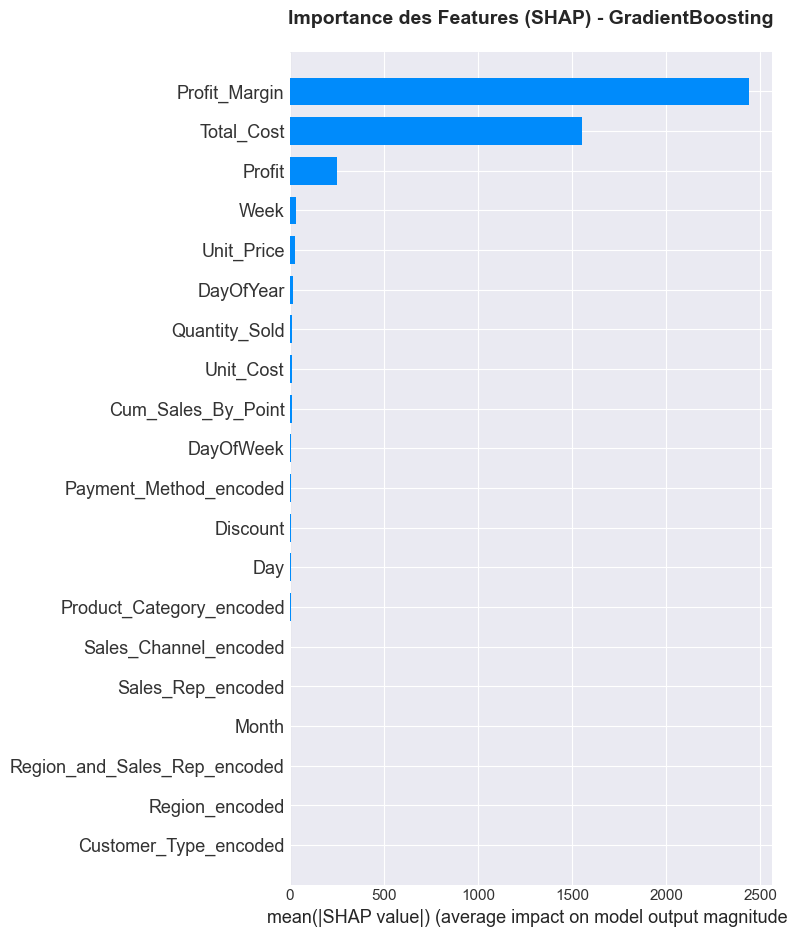

In [66]:
# Graphique d'importance globale des features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title(f'Importance des Features (SHAP) - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


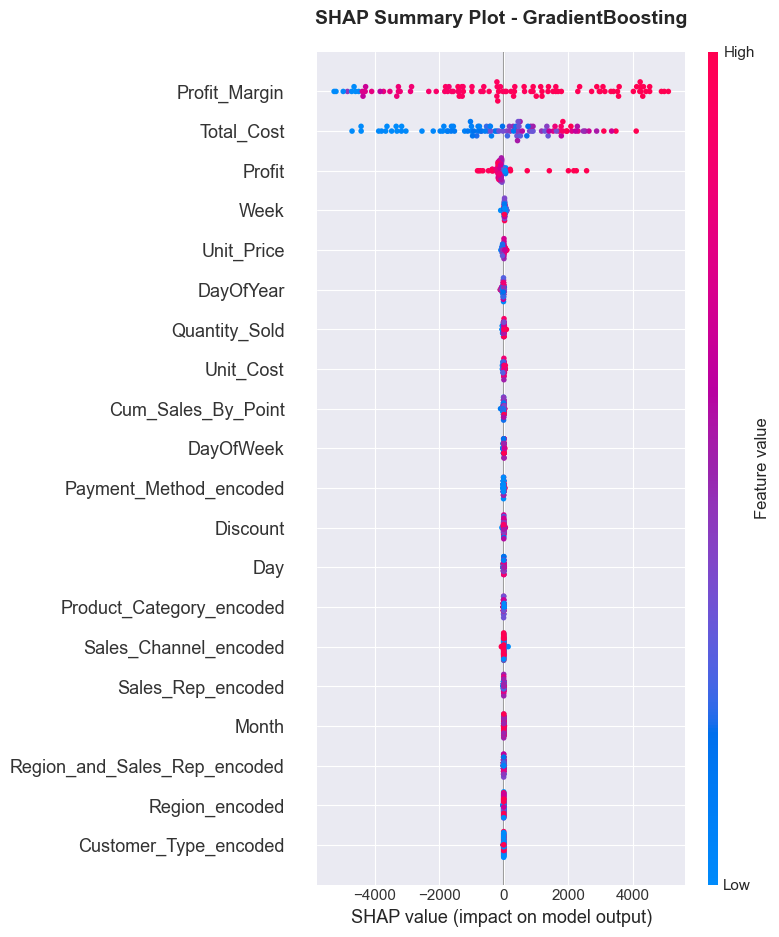

In [67]:
# Graphique SHAP summary plot (beeswarm)
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()


Top 15 des features les plus importantes (SHAP):
                 Feature  SHAP_Importance
           Profit_Margin          2438.78
              Total_Cost          1554.86
                  Profit           252.83
                    Week            34.29
              Unit_Price            27.36
               DayOfYear            19.45
           Quantity_Sold            14.74
               Unit_Cost            13.53
      Cum_Sales_By_Point            10.04
               DayOfWeek             8.54
  Payment_Method_encoded             7.70
                Discount             7.19
                     Day             6.47
Product_Category_encoded             4.91
   Sales_Channel_encoded             4.37


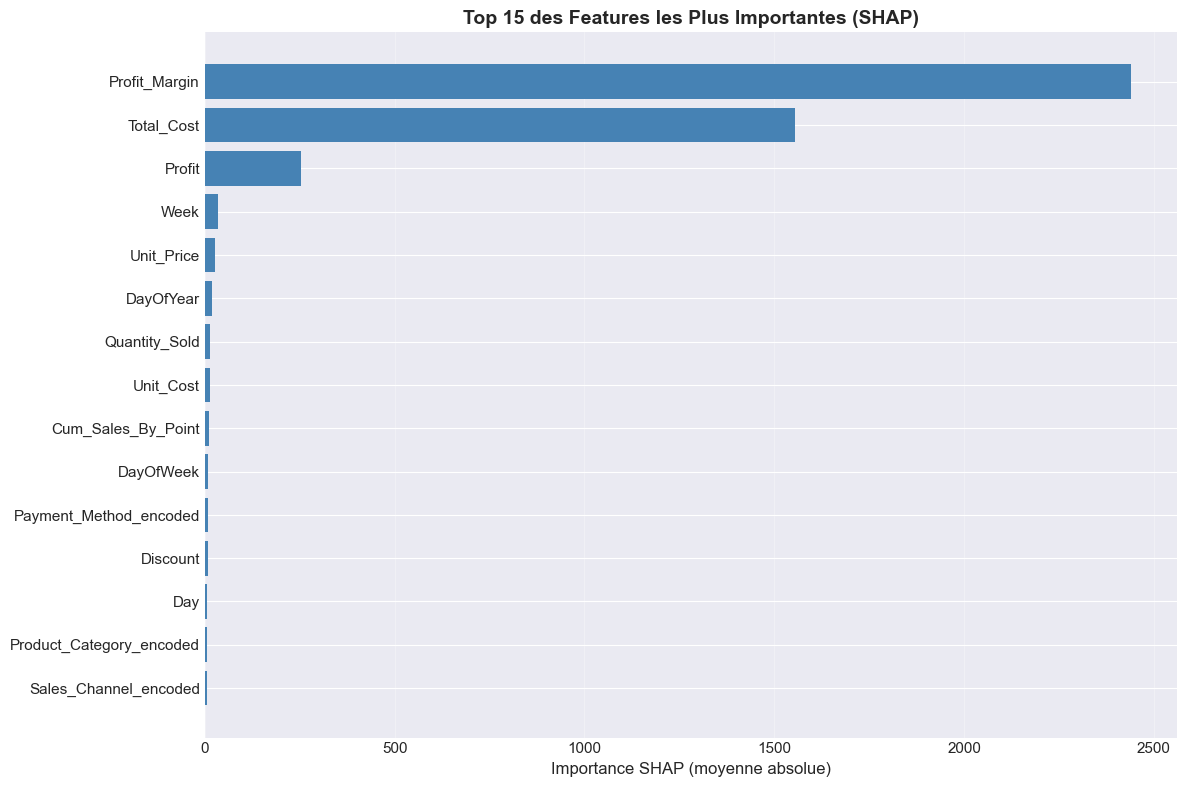

In [68]:
# Calcul de l'importance moyenne des features
if isinstance(shap_values, list):
    shap_values_mean = np.abs(shap_values).mean(0)
else:
    shap_values_mean = np.abs(shap_values).mean(0)

feature_importance_df = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'SHAP_Importance': shap_values_mean
}).sort_values('SHAP_Importance', ascending=False)

print("Top 15 des features les plus importantes (SHAP):")
print("=" * 60)
print(feature_importance_df.head(15).to_string(index=False))

# Visualisation
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['SHAP_Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance SHAP (moyenne absolue)', fontsize=12)
plt.title('Top 15 des Features les Plus Importantes (SHAP)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'shap_top_features.png', dpi=300, bbox_inches='tight')
plt.show()


Exemple d'explication SHAP pour un échantillon:
  Valeur réelle: 8518.45
  Prédiction: 8818.70
  Erreur: 300.25


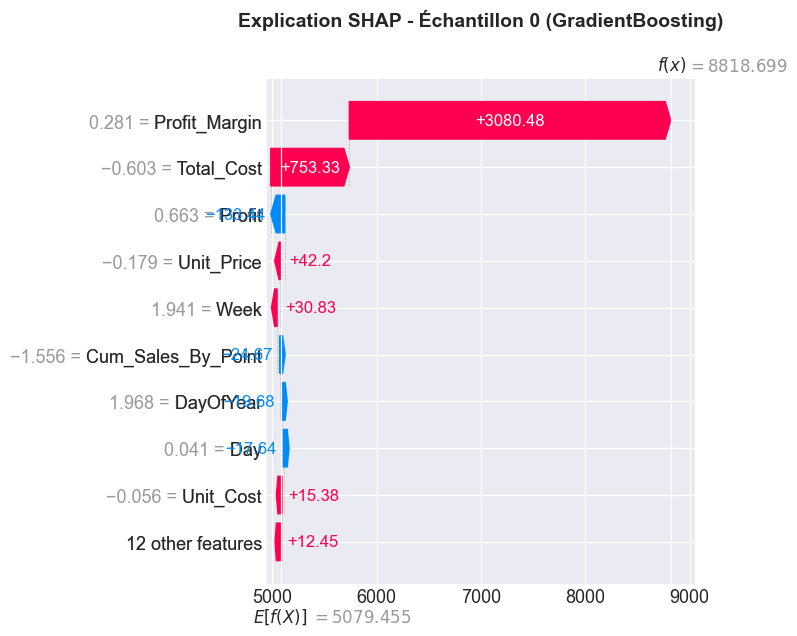

In [69]:
# Exemple d'explication pour une prédiction individuelle
sample_idx = 0
sample_prediction = best_model.predict(X_test_sample.iloc[[sample_idx]])[0]
sample_actual = y_test.iloc[sample_idx]

print(f"Exemple d'explication SHAP pour un échantillon:")
print(f"  Valeur réelle: {sample_actual:.2f}")
print(f"  Prédiction: {sample_prediction:.2f}")
print(f"  Erreur: {abs(sample_actual - sample_prediction):.2f}")

# Waterfall plot pour un échantillon (si disponible)
try:
    if hasattr(explainer, 'expected_value'):
        expected_value = explainer.expected_value
        if isinstance(expected_value, np.ndarray):
            expected_value = expected_value[0]
        
        plt.figure(figsize=(12, 8))
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[sample_idx] if not isinstance(shap_values, list) else shap_values[sample_idx],
                base_values=expected_value,
                data=X_test_sample.iloc[sample_idx].values,
                feature_names=X_test_sample.columns.tolist()
            ),
            show=False
        )
        plt.title(f'Explication SHAP - Échantillon {sample_idx} ({best_model_name})', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'figures' / 'shap_waterfall_example.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print(f"Note: Waterfall plot non disponible pour ce type de modèle ({e})")


# Validation

Validation croisée et métriques finales pour s'assurer de la robustesse du modèle.


In [70]:
# Validation croisée avec TimeSeriesSplit pour respecter l'ordre temporel
tscv = TimeSeriesSplit(n_splits=5)

print("Validation croisée avec TimeSeriesSplit (5 folds)...")
cv_scores = cross_val_score(
    best_model, 
    X_train_scaled, 
    y_train, 
    cv=tscv, 
    scoring='r2',
    n_jobs=-1
)

print(f"\nR² Scores par fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nR² Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Écart-type: {cv_scores.std():.4f}")


Validation croisée avec TimeSeriesSplit (5 folds)...

R² Scores par fold:
  Fold 1: 0.6326
  Fold 2: 0.8948
  Fold 3: 0.9509
  Fold 4: 0.9651
  Fold 5: 0.9681

R² Score moyen: 0.8823 (+/- 0.2552)
Écart-type: 0.1276


In [71]:
# Validation croisée avec d'autres métriques
cv_metrics = {
    'r2': cross_val_score(best_model, X_train_scaled, y_train, cv=tscv, scoring='r2', n_jobs=-1),
    'neg_mean_absolute_error': cross_val_score(best_model, X_train_scaled, y_train, cv=tscv, 
                                               scoring='neg_mean_absolute_error', n_jobs=-1),
    'neg_mean_squared_error': cross_val_score(best_model, X_train_scaled, y_train, cv=tscv, 
                                               scoring='neg_mean_squared_error', n_jobs=-1),
    'neg_root_mean_squared_error': cross_val_score(best_model, X_train_scaled, y_train, cv=tscv, 
                                                    scoring='neg_root_mean_squared_error', n_jobs=-1)
}

cv_results_df = pd.DataFrame({
    'R²': cv_metrics['r2'],
    'MAE': -cv_metrics['neg_mean_absolute_error'],
    'MSE': -cv_metrics['neg_mean_squared_error'],
    'RMSE': -cv_metrics['neg_root_mean_squared_error']
})

print("Résultats de la validation croisée (5 folds):")
print("=" * 70)
print(cv_results_df.round(4))
print("\nMoyennes:")
print(cv_results_df.mean().round(4))
print("\nÉcart-types:")
print(cv_results_df.std().round(4))


Résultats de la validation croisée (5 folds):
     R²      MAE       MSE     RMSE
0  0.63  1247.08  2.86e+06  1692.50
1  0.89   630.01  8.60e+05   927.40
2  0.95   445.93  3.84e+05   619.73
3  0.97   398.66  2.70e+05   519.62
4  0.97   370.87  2.57e+05   506.88

Moyennes:
R²           0.88
MAE        618.51
MSE     927124.24
RMSE       853.23
dtype: float64

Écart-types:
R²      1.43e-01
MAE     3.66e+02
MSE     1.11e+06
RMSE    4.99e+02
dtype: float64


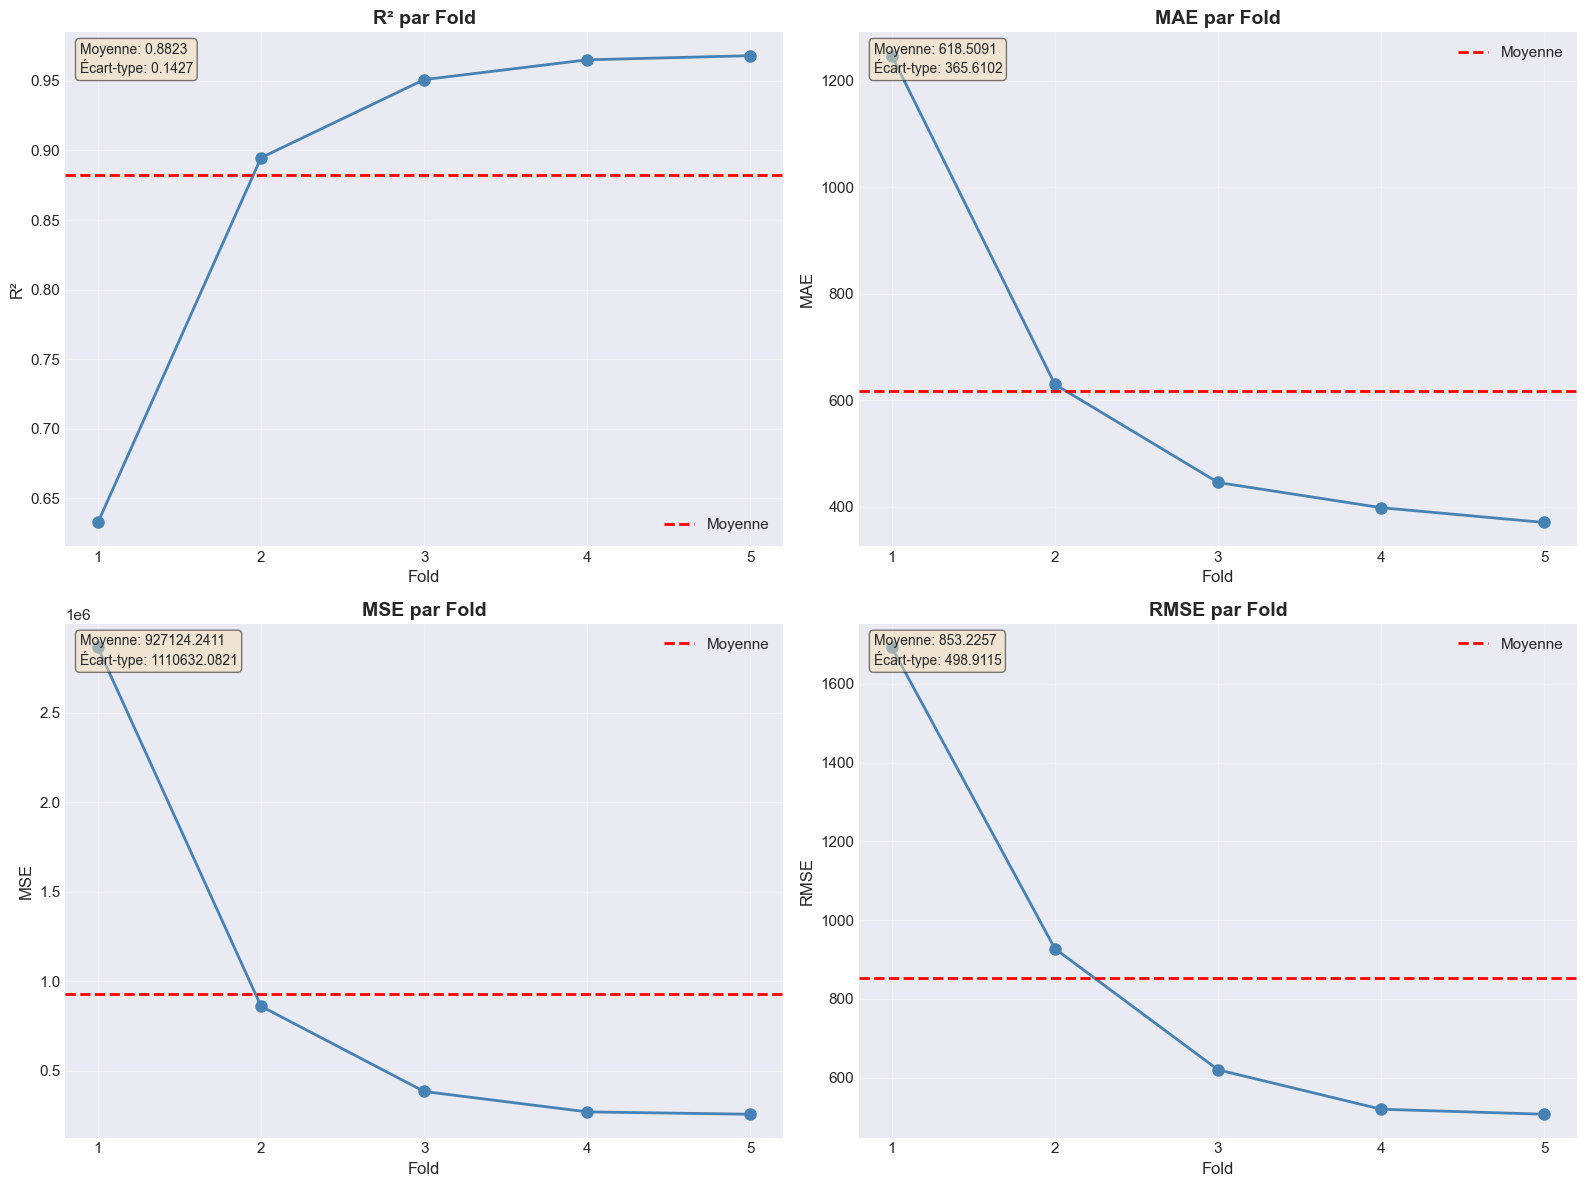

In [72]:
# Visualisation des résultats de validation croisée
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['R²', 'MAE', 'MSE', 'RMSE']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    ax.plot(range(1, 6), cv_results_df[metric], marker='o', linewidth=2, markersize=8, color='steelblue')
    ax.axhline(y=cv_results_df[metric].mean(), color='red', linestyle='--', linewidth=2, label='Moyenne')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} par Fold', fontsize=14, fontweight='bold')
    ax.set_xticks(range(1, 6))
    ax.grid(alpha=0.3)
    ax.legend()
    ax.text(0.02, 0.98, f'Moyenne: {cv_results_df[metric].mean():.4f}\nÉcart-type: {cv_results_df[metric].std():.4f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'cross_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [73]:
# Résumé final des performances
final_summary = {
    'Modèle': best_model_name,
    'Train_R²': results[best_model_name]['train_r2'],
    'Test_R²': results[best_model_name]['test_r2'],
    'CV_R²_Mean': cv_scores.mean(),
    'CV_R²_Std': cv_scores.std(),
    'Test_RMSE': results[best_model_name]['test_rmse'],
    'Test_MAE': results[best_model_name]['test_mae'],
    'Test_MAPE': results[best_model_name]['test_mape'],
    'Temps_entraînement': results[best_model_name]['elapsed_time']
}

print("=" * 80)
print("RÉSUMÉ FINAL DES PERFORMANCES")
print("=" * 80)
for key, value in final_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Sauvegarde du résumé
summary_path = OUTPUT_DIR / 'reports' / 'final_summary.json'
with open(summary_path, 'w') as f:
    json.dump({k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
               for k, v in final_summary.items()}, f, indent=2, default=str)
print(f"\nRésumé sauvegardé: {summary_path}")


RÉSUMÉ FINAL DES PERFORMANCES
Modèle: GradientBoosting
Train_R²: 0.9987
Test_R²: 0.9750
CV_R²_Mean: 0.8823
CV_R²_Std: 0.1276
Test_RMSE: 450.8167
Test_MAE: 311.2445
Test_MAPE: 0.1019
Temps_entraînement: 0.8048

Résumé sauvegardé: output\reports\final_summary.json


# Génération du Rapport

Création d'un rapport final récapitulatif avec tous les résultats et visualisations.


In [74]:
# Génération du rapport final
report_path = OUTPUT_DIR / 'reports' / 'rapport_final.md'

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("# Rapport d'Analyse Prédictive des Ventes\n\n")
    f.write(f"**Date de génération:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("## 1. Résumé Exécutif\n\n")
    f.write("Ce rapport présente les résultats de l'analyse prédictive des ventes, incluant:\n")
    f.write("- Le nettoyage et la validation des données\n")
    f.write("- L'ingénierie des features\n")
    f.write("- L'analyse exploratoire des données (EDA)\n")
    f.write("- La modélisation prédictive avec plusieurs algorithmes\n")
    f.write("- L'interprétabilité avec SHAP\n")
    f.write("- La validation des modèles\n\n")
    
    f.write("## 2. Données\n\n")
    f.write(f"- **Nombre total d'échantillons:** {len(df):,}\n")
    f.write(f"- **Période d'analyse:** {df['Sale_Date'].min().strftime('%Y-%m-%d')} à {df['Sale_Date'].max().strftime('%Y-%m-%d')}\n")
    f.write(f"- **Nombre de features:** {len(all_features)}\n")
    f.write(f"- **Jeu d'entraînement:** {len(X_train):,} échantillons ({len(X_train)/len(X)*100:.1f}%)\n")
    f.write(f"- **Jeu de test:** {len(X_test):,} échantillons ({len(X_test)/len(X)*100:.1f}%)\n\n")
    
    f.write("## 3. Modèles Testés\n\n")
    f.write("Les modèles suivants ont été entraînés et évalués:\n")
    for name in models.keys():
        f.write(f"- {name}\n")
    f.write("\n")
    
    f.write("## 4. Résultats des Modèles\n\n")
    f.write("### 4.1 Comparaison des Performances\n\n")
    f.write("| Modèle | R² (Test) | RMSE (Test) | MAE (Test) | MAPE (Test) |\n")
    f.write("|--------|-----------|-------------|------------|-------------|\n")
    for name in comparison_df.index:
        f.write(f"| {name} | {comparison_df.loc[name, 'test_r2']:.4f} | "
                f"{comparison_df.loc[name, 'test_rmse']:.2f} | "
                f"{comparison_df.loc[name, 'test_mae']:.2f} | "
                f"{comparison_df.loc[name, 'test_mape']:.4f} |\n")
    f.write("\n")
    
    f.write(f"### 4.2 Meilleur Modèle: {best_model_name}\n\n")
    f.write(f"- **R² Score (Train):** {results[best_model_name]['train_r2']:.4f}\n")
    f.write(f"- **R² Score (Test):** {results[best_model_name]['test_r2']:.4f}\n")
    f.write(f"- **RMSE (Test):** {results[best_model_name]['test_rmse']:.2f}\n")
    f.write(f"- **MAE (Test):** {results[best_model_name]['test_mae']:.2f}\n")
    f.write(f"- **MAPE (Test):** {results[best_model_name]['test_mape']:.4f}\n")
    f.write(f"- **Explained Variance Score (Test):** {results[best_model_name]['test_evs']:.4f}\n\n")
    
    f.write("### 4.3 Validation Croisée\n\n")
    f.write(f"- **R² Score moyen:** {cv_scores.mean():.4f}\n")
    f.write(f"- **Écart-type:** {cv_scores.std():.4f}\n")
    f.write(f"- **Min:** {cv_scores.min():.4f}\n")
    f.write(f"- **Max:** {cv_scores.max():.4f}\n\n")
    
    f.write("## 5. Interprétabilité (SHAP)\n\n")
    f.write("### 5.1 Top 10 Features les Plus Importantes\n\n")
    f.write("| Rang | Feature | Importance SHAP |\n")
    f.write("|------|---------|------------------|\n")
    for idx, row in feature_importance_df.head(10).iterrows():
        f.write(f"| {idx + 1} | {row['Feature']} | {row['SHAP_Importance']:.4f} |\n")
    f.write("\n")
    
    f.write("## 6. Visualisations Générées\n\n")
    f.write("Les visualisations suivantes ont été sauvegardées dans `output/figures/`:\n")
    f.write("- `model_comparison.png`: Comparaison des métriques des modèles\n")
    f.write("- `predictions_vs_reality.png`: Prédictions vs valeurs réelles\n")
    f.write("- `shap_feature_importance.png`: Importance des features (SHAP)\n")
    f.write("- `shap_summary_plot.png`: Summary plot SHAP\n")
    f.write("- `shap_top_features.png`: Top 15 des features les plus importantes\n")
    f.write("- `cross_validation_results.png`: Résultats de la validation croisée\n\n")
    
    f.write("## 7. Modèles Sauvegardés\n\n")
    f.write(f"- **Meilleur modèle:** `output/models/best_model_{best_model_name.lower()}.joblib`\n")
    f.write(f"- **Scaler:** `output/models/scaler.joblib`\n\n")
    
    f.write("## 8. Conclusions\n\n")
    f.write(f"Le modèle {best_model_name} a été sélectionné comme meilleur modèle avec un R² de "
            f"{results[best_model_name]['test_r2']:.4f} sur le jeu de test.\n\n")
    f.write("### Recommandations:\n\n")
    f.write("1. **Suivi des ventes:** Utiliser le modèle pour prédire les ventes futures\n")
    f.write("2. **Optimisation des discounts:** Réduire les discounts pour améliorer la rentabilité\n")
    f.write("3. **Détection de fraude:** Mettre en place un système de détection pour les écarts entre valeurs enregistrées et calculées\n")
    f.write("4. **Focus sur les features importantes:** Se concentrer sur les features identifiées par SHAP comme les plus importantes\n\n")
    
    f.write("---\n\n")
    f.write("*Rapport généré automatiquement par le pipeline d'analyse prédictive*\n")

print(f"Rapport final généré: {report_path}")


Rapport final généré: output\reports\rapport_final.md


In [75]:
# Affichage du résumé final dans le notebook
print("=" * 80)
print("RAPPORT FINAL - RÉSUMÉ")
print("=" * 80)
print(f"\n Projet: Analyse Prédictive des Ventes")
print(f" Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n Données:")
print(f"   - Total: {len(df):,} échantillons")
print(f"   - Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n Meilleur Modèle: {best_model_name}")
print(f"   - R² Score (Test): {results[best_model_name]['test_r2']:.4f}")
print(f"   - RMSE (Test): {results[best_model_name]['test_rmse']:.2f}")
print(f"   - MAE (Test): {results[best_model_name]['test_mae']:.2f}")

print(f"\n Validation Croisée:")
print(f"   - R² moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print(f"\n Top 5 Features (SHAP):")
for idx, row in feature_importance_df.head(5).iterrows():
    print(f"   {idx + 1}. {row['Feature']}: {row['SHAP_Importance']:.4f}")

print(f"\n Fichiers générés:")
print(f"   - Modèle: output/models/best_model_{best_model_name.lower()}.joblib")
print(f"   - Scaler: output/models/scaler.joblib")
print(f"   - Rapport: output/reports/rapport_final.md")
print(f"   - Résultats: output/reports/model_results.json")
print(f"   - Visualisations: output/figures/")

print("\n" + "=" * 80)
print(" PROJET TERMINÉ AVEC SUCCÈS!")
print("=" * 80)


RAPPORT FINAL - RÉSUMÉ

 Projet: Analyse Prédictive des Ventes
 Date: 2025-11-16 17:07:22

 Données:
   - Total: 1,000 échantillons
   - Train: 800 (80.0%)
   - Test: 200 (20.0%)

 Meilleur Modèle: GradientBoosting
   - R² Score (Test): 0.9750
   - RMSE (Test): 450.82
   - MAE (Test): 311.24

 Validation Croisée:
   - R² moyen: 0.8823 (+/- 0.2552)

 Top 5 Features (SHAP):
   13. Profit_Margin: 2438.7788
   11. Total_Cost: 1554.8578
   12. Profit: 252.8268
   10. Week: 34.2913
   3. Unit_Price: 27.3565

 Fichiers générés:
   - Modèle: output/models/best_model_gradientboosting.joblib
   - Scaler: output/models/scaler.joblib
   - Rapport: output/reports/rapport_final.md
   - Résultats: output/reports/model_results.json
   - Visualisations: output/figures/

 PROJET TERMINÉ AVEC SUCCÈS!
